# Recommender Systems

## Import Libraries

In [4]:
import pandas as pd
import missingno as msno
import numpy as np
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore','FutureWarnings')

## Import Dataset

In [5]:
users = pd.read_parquet('./users_prep.parquet.gzip')

In [6]:
books = pd.read_parquet('./books_prep.parquet.gzip')

In [7]:
ratings = pd.read_parquet('./ratings_prep.parquet.gzip')

In [8]:
print('The shape of Ratings is: ' + str(ratings.shape))
print('The shape of Users is: ' + str(users.shape))
print('The shape of Books is: ' + str(books.shape))

The shape of Ratings is: (433671, 3)
The shape of Users is: (278858, 5)
The shape of Books is: (271357, 5)


## Sampling Dataset

In [9]:
def popular_ratings(ratings, user_threshold=200, rating_threshold=200, book_threshold=1):
    counts_users = ratings.userId.value_counts()
    counts_ratings = ratings.bookRating.value_counts()
    sample_ratings = ratings[ratings['userId'].isin(counts_users[counts_users >= user_threshold].index)]
    sample_ratings = sample_ratings[ratings['bookRating'].isin(counts_ratings[counts_ratings >= rating_threshold].index)]
    isbn_group = sample_ratings.groupby('ISBN', as_index=False)['bookRating'].count()
    sample_ratings = sample_ratings[sample_ratings.ISBN.isin(list(isbn_group[isbn_group.bookRating > book_threshold].ISBN.values))]
    return sample_ratings

In [10]:
sampled_ratings = popular_ratings(ratings, user_threshold=400, rating_threshold=400, book_threshold=1)
print('Sample Ratings Shape', sampled_ratings.shape)
book_ratings = sampled_ratings.pivot_table(index='userId', columns='ISBN', values='bookRating').fillna(0)
print('Book Ratings Shape', book_ratings.shape)
book_ratings.head()

<ipython-input-9-fefc012b949f>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sample_ratings = sample_ratings[ratings['bookRating'].isin(counts_ratings[counts_ratings >= rating_threshold].index)]


Sample Ratings Shape (9441, 3)
Book Ratings Shape (43, 4002)


ISBN,0001056107,0002570122,0006379702,0006514855,0006547613,0006550681,0006550789,0007110928,0007144350,0007154615,...,8433551175,8437600685,8440693478,8466609016,8474440556,8474444314,8478801960,8485224752,9500700891,9500723549
userId,,,,,,,,,,,,,,,,,,,,,
3757,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7.0,0.0,0.0,0.0,8.0,0.0,7.0,5.0,0.0,0.0
11676,0.0,0.0,5.0,7.0,0.0,8.0,7.0,7.0,0.0,7.0,...,0.0,0.0,2.0,7.0,6.0,3.0,6.0,10.0,0.0,6.0
16795,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23872,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23902,0.0,0.0,0.0,0.0,8.0,0.0,0.0,8.0,10.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
user_id_list = book_ratings.index.tolist()
column_names = ["userId", "location", "age"]
sampled_users = pd.DataFrame(columns = column_names)
sampled_users = users.loc[users['userId'].isin(user_id_list)]
sampled_users = sampled_users.reset_index()
sampled_users = sampled_users.drop(['index'], axis=1)

sampled_users.head()

,userId,age,city,state,country
0,3757,10,madrid,madrid,spain
1,11676,39,n/a,n/a,n/a
2,16795,47,mechanicsville,maryland,usa
3,23872,22,tulsa,oklahoma,usa
4,23902,32,london,england,united kingdom


In [12]:
book_isbn_list = book_ratings.columns.values.tolist()
# print(len(book_isbn_list)) # 8621
column_names = ["ISBN", "bookTitle", "bookAuthor", "yearOfPublication", "publisher"]
sampled_books = pd.DataFrame(columns = column_names)
sampled_books = books.loc[books['ISBN'].isin(book_isbn_list)]
sampled_books = sampled_books.reset_index()
sampled_books = sampled_books.drop(['index'], axis=1)
# print(len(sampled_books)) # 8324
sampled_books.head()

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
0,0440234743,The Testament,John Grisham,1999,Dell
1,0971880107,Wild Animus,Rich Shapero,2004,Too Far
2,0345417623,Timeline,MICHAEL CRICHTON,2000,Ballantine Books
3,0446310786,To Kill a Mockingbird,Harper Lee,1988,Little Brown &; Company
4,0449005615,Seabiscuit: An American Legend,LAURA HILLENBRAND,2002,Ballantine Books


## 1. Collaborative Filtering

### 1.1 Item Based Collaborative Filtering

In [140]:
class ItemBasedCollaborativeFiltering():    
    
    def __init__(self, users, books, ratings, k=10, max_rating=10.0):
        self.users = users
        self.users = self.users.reset_index()
        self.users = self.users.drop(columns=['index'])
        
        self.books = books
        
        self.ratings = ratings
        self.ratings = self.ratings.reset_index()
        self.ratings = self.ratings.drop(columns=['userId'])
        
        self.k = k
        self.max_rating = max_rating
        
        self.frequencies = {}
        self.deviations = {}
        
    
    def prepare_data(self):
                
        user_indices = list(self.ratings.index.values)

        users_ratings = []
        for user_index in user_indices:
            rated_book_indices = list(self.ratings.iloc[user_index].to_numpy().nonzero()[0])
            users_ratings.append({user_index: dict(self.ratings[self.ratings.columns[rated_book_indices]].iloc[user_index])})
    
        self.users_ratings = users_ratings
        
        return self.users_ratings
        
        
    def compute_deviations(self):
        users_ratings = self.users_ratings
        num_users = len(self.users)
        
        for i in range(num_users):
            for ratings in self.users_ratings[i].values():
                for item, rating in ratings.items():
                    self.frequencies.setdefault(item, {})
                    self.deviations.setdefault(item, {})
                    
                    for (item2, rating2) in ratings.items():
                        if item != item2:
                            self.frequencies[item].setdefault(item2, 0)
                            self.deviations[item].setdefault(item2, 0.0)
                            self.frequencies[item][item2] += 1
                            self.deviations[item][item2] += rating - rating2
            
            for (item, ratings) in self.deviations.items():
                for item2 in ratings:
                    ratings[item2] /= self.frequencies[item][item2]
    
    
    def slope_one_recommend(self, user_ratings):
        recommendations = {}
        frequencies = {}
        
        for (user_item, user_rating) in user_ratings.items():
        
            for (diff_item, diff_ratings) in self.deviations.items():
                if diff_item not in user_ratings and user_item in self.deviations[diff_item]:
                    freq = self.frequencies[diff_item][user_item]
                    recommendations.setdefault(diff_item, 0.0)
                    frequencies.setdefault(diff_item, 0)
        
                    recommendations[diff_item] += (diff_ratings[user_item] + user_rating) * freq
                    frequencies[diff_item] += freq
        
        recommendations = [(k, v / frequencies[k]) for (k, v) in recommendations.items()]
        
        recommendations.sort(key=lambda ratings: ratings[1], reverse = True)
        
        return recommendations
    
    
    def recommend(self, recommendations):
        top_k_recommendations = recommendations[: self.k]
        
        isbns = [recommendation[0] for recommendation in top_k_recommendations]
        
        recommended_books = [self.books.loc[self.books['ISBN'] == isbn] for isbn in isbns]
        return pd.concat(recommended_books)

In [141]:
item_cf = ItemBasedCollaborativeFiltering(sampled_users, sampled_books, book_ratings)

In [142]:
users_ratings = item_cf.prepare_data()

In [143]:
item_cf.compute_deviations()

In [163]:
user_index = 1
pd.DataFrame(sampled_users.iloc[user_index])

,1
userId,11676
age,39
city,n/a
state,n/a
country,n/a


In [164]:
recommendations = item_cf.slope_one_recommend(users_ratings[user_index][user_index])

In [165]:
item_cf.recommend(recommendations)

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
2949,0385419287,The 776 Stupidest Things Ever Said,Ross Petras,1993,Main Street Books
1217,0140183515,Just So Stories (Penguin Twentieth-Century Cla...,Rudyard Kipling,1990,Penguin Books
1757,0394747232,Maus a Survivors Tale: My Father Bleeds History,Art Spiegelman,1986,Pantheon Books
3296,0373078110,Hidden Star (The Stars Of Mithra) (Harlequin ...,Nora Roberts,1997,Silhouette
2864,0373078358,Secret Star (The Stars Of Mithra) (Harlequin ...,Nora Roberts,1998,Silhouette
1183,0373218419,Blithe Images,Nora Roberts,2003,Silhouette
2791,0373218486,Going Home: Unfinished Business/ Island of Flo...,Nora Roberts,2002,Silhouette
2477,0373218540,Dangerous,Nora Roberts,2002,Silhouette
383,0373242328,The Perfect Neighbor (The Macgregors) (The Mac...,Nora Roberts,1999,Silhouette
1553,0373243286,"Irish Rebel (Special Edition, 1328)",Nora Roberts,2000,Silhouette


### 1.2 User Based Collaborative Filtering

In [166]:
class UserBasedCollaborativeFiltering():
    
    def __init__(self, users, books, ratings, k=10, max_rating=10.0):
        self.users = users
        self.users = self.users.reset_index()
        self.users = self.users.drop(columns=['index'])
        
        self.books = books
        
        self.ratings = ratings
        self.ratings = self.ratings.reset_index()
        self.ratings = self.ratings.drop(columns=['userId'])
        
        self.k = k
        self.max_rating = max_rating
    
    def normalize(self, dataframe):

        row_sum_ratings = dataframe.sum(axis=1) # sum entries of rows
        non_zero_count = dataframe.astype(bool).sum(axis=1) # count non-zero entries of rows 
        
        dataframe_mean = row_sum_ratings / non_zero_count # mean of rows
        
        self.normalized_ratings = dataframe.subtract(dataframe_mean, axis = 0) # subtract on rows(iteration over columns!)
    
    def compute_similarity(self, x, y):
        return np.dot(x, y)/ (np.linalg.norm(x) * np.linalg.norm(y))


    def create_similarity_matrix(self):          
        num_users = len(self.users)
        similarity_array = np.array([self.compute_similarity(self.ratings.iloc[i,:], self.ratings.iloc[j,:])
                                    for i in range(num_users) for j in range(num_users)])
        similarity_matrix = pd.DataFrame(data = similarity_array.reshape(self.users.shape[0], self.users.shape[0]))
        
        return similarity_matrix
    
    
#     def create_similarity_matrix(self):
#         num_users = len(self.users)
#         similarity_array = np.array([self.compute_similarity(self.ratings.iloc[i,:], self.ratings.iloc[j,:])
#                                     for i in range(num_users) for j in range(num_users)])
#         similarity_matrix = pd.DataFrame(data = similarity_array.reshape(self.users.shape[0], self.users.shape[0]),
#                                         index = self.users['userId'])
#         similarity_matrix.columns = self.users['userId']
#         return similarity_matrix
    

    def get_neighbors(self, user_id, similarity_matrix):
        user_index = self.users.loc[self.users['userId'] == user_id].index.values[0]
        user_similairities = similarity_matrix.iloc[user_index].values
        temp_neighbors_index = user_similairities.argsort()[-(self.k + 1):][::-1]
        neighbor_index = np.delete(temp_neighbors_index, np.where(temp_neighbors_index[user_index] == user_index))

        return neighbor_index    

#     def get_neighbors(self, user_id, similarity_matrix):
#         user_index = self.users.loc[self.users['userId'] == user_id].index.values[0]
#         user_similairities = similarity_matrix.iloc[user_index].values
#         temp_neighbors_index = user_similairities.argsort()[::-1]
        
#         similarity_indices = list(similarity_matrix.iloc[user_index].index)
        
#         neighbor_sim_scores = {}
#         for index in temp_neighbors_index:
#             if index != user_index:
#                 id = similarity_indices[index]
#                 neighbor_sim_scores[id] = user_similairities[index]
        
#         return neighbor_sim_scores
    
    
#     def get_raters(self, isbn):
#         raters = self.ratings[isbn]
#         user_ids = list(raters[raters != 0].index)
#         return user_ids
    
#     def get_unrated_books(self, user_id):
#         user_index = self.users.loc[self.users['userId'] == user_id].index.values[0]
#         all_books = self.ratings.iloc[user_index]
#         unrated_books = list(all_books[all_books == 0].index)
#         return unrated_books # ISBNs
        
    def score_item(self, user_id, neighbor_rating, neighbor_similarity, ratings):
        user_index = self.users.loc[self.users['userId'] == user_id].index.values[0]
        active_user_mean_rating = np.mean(ratings.iloc[user_index, :])
        score = np.dot(neighbor_similarity, neighbor_rating) + active_user_mean_rating
        data = score.reshape(1, len(score))
        columns = neighbor_rating.columns
        return pd.DataFrame(data= data , columns= columns)
    
    
#     def predict_scores(self, user_id, neighbor_sim_scores):
#         user_index = self.users.loc[self.users['userId'] == user_id].index.values[0]
#         unrated_books = self.get_unrated_books(user_id)
                
#         num_neighbors = len(neighbor_sim_scores)
        
#         predicted_ratings = {}
#         for isbn in unrated_books:
#             neighbor_counter = 0
#             all_neighbors = []
#             k_nearest_neighbors = []
#             raters = self.get_raters(isbn)
            
#             for neighbor_id, sim_score in neighbor_sim_scores.items():
#                 if neighbor_id in raters:
#                     neighbor_counter += 1
#                     all_neighbors.append((neighbor_id, sim_score))
        
#             if neighbor_counter > self.k:
#                 k_nearest_neighbors = all_neighbors[: self.k]
#             else:
#                 k_nearest_neighbors = all_neighbors
            
#             predicted_score = self.compute_score(user_id, isbn, k_nearest_neighbors)
#             predicted_ratings[isbn] = predicted_score
        
#         return predicted_ratings
                        
#     def compute_score(self, user_id, isbn, neighbors):
#         user_index = self.users.loc[self.users['userId'] == user_id].index.values[0]
        
#         ids = [neighbor[0] for neighbor in neighbors]
#         sim_scores = [neighbor[1] for neighbor in neighbors]
        
#         nominator = 0
#         for id in ids:
#             nominator += similarity_matrix[id].iloc[user_id] * self.normalized_ratings[isbn].loc[id]
        
#         denominator = sum(sim_scores)
        
#         # no similarity score means there is no neighbor for this user and this means that Utility matrix is so sparse.
#         if denominator == 0: 
#             return -1
        
#         return nominator / denominator
            

    def recommend(self, user_id):
        user_index = self.users.loc[self.users['userId'] == user_id].index.values[0]
        user_ratings = book_ratings.iloc[user_index]
        recommendation_columns = []

        for i in range(len(user_ratings.index)):
            isbn = user_ratings.index[i]
            rating = user_ratings.values[i]
            if rating == 0.0:
                recommendation_columns.append(isbn)

        self.normalize(self.ratings)  
        similarity_matrix = self.create_similarity_matrix()
        neighbor_index = self.get_neighbors(user_id, similarity_matrix)
        neighbor_rating = self.normalized_ratings.loc[neighbor_index][recommendation_columns]
        neighbor_similarity = similarity_matrix[user_index].loc[neighbor_index]
        recommendation_score = self.score_item(user_id, neighbor_rating, neighbor_similarity, self.ratings)
        recommended_book_ISBNs = recommendation_score.stack().nlargest(self.k)
        recommended_book_ISBNs = [recommended_book_ISBNs.index.values[i][1] for i in range(len(recommended_book_ISBNs))]
        recommended_books = self.books.loc[self.books['ISBN'].isin(recommended_book_ISBNs)]

        return recommended_books
    
    
#     def recommend(self, user_id):
#         user_index = self.users.loc[self.users['userId'] == user_id].index.values[0]
#         user_ratings = book_ratings.iloc[user_index]
        
#         normalized_ratings= self.normalize(self.ratings)  
#         similarity_matrix = self.create_similarity_matrix()
        
#         neighbor_sim_scores = self.get_neighbors(user_id, similarity_matrix)
#         predicted_ratings = self.predict_scores(user_id, neighbor_sim_scores)
        
#         isbns_to_recommend = dict(sorted(predicted_ratings.items(), key=lambda item: item[1], reverse=True)[:self.k]).keys()
#         recommended_books = self.books.loc[self.books['ISBN'].isin(isbns_to_recommend)]
                
#         return recommended_books


In [167]:
user_based_cf = UserBasedCollaborativeFiltering(sampled_users, sampled_books, book_ratings)

In [168]:
similarity_matrix = user_based_cf.create_similarity_matrix()

In [169]:
user_id = 23872
recommendations = user_based_cf.recommend(user_id)

In [170]:
recommendations.head(10)

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
52,1558744150,Chicken Soup for the Woman's Soul (Chicken Sou...,Jack Canfield,1996,Health Communications
97,0842329129,Left Behind: A Novel of the Earth's Last Days ...,Tim Lahaye,1996,Tyndale House Publishers
134,0061009059,One for the Money (Stephanie Plum Novels (Pape...,Janet Evanovich,1995,HarperTorch
219,0345370775,Jurassic Park,Michael Crichton,1999,Ballantine Books
267,080410753X,The Kitchen God's Wife,Amy Tan,1992,Ivy Books
385,059035342X,Harry Potter and the Sorcerer's Stone (Harry P...,J. K. Rowling,1999,Arthur A. Levine Books
489,0399146431,The Bonesetter's Daughter,Amy Tan,2001,Putnam Publishing Group
786,043935806X,Harry Potter and the Order of the Phoenix (Boo...,J. K. Rowling,2003,Scholastic
1726,0811801802,Sabine's Notebook: In Which the Extraordinary ...,Nick Bantock,1992,Chronicle Books
1779,0877017883,Griffin &amp; Sabine: An Extraordinary Corresp...,Nick Bantock,1991,Chronicle Books


## 2. Content-based Filtering

In [26]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re

#remove every char that is not a-z or 0-9 
#if(combine=True) remove every space in string
#convert lower to upper case
def clean_fields(x, combine=False):
    """clean string field"""
    x = x.lower()
    x = re.sub('[^a-z0-9 ]', '', x)
    if combine:
        return ''.join(x.replace(' ', '') for x in x).strip()
    return x.strip()

# sort and return top
# lambda is a keyword used to define anonymous functions example: addition = lambda num1, num2: num1 + num2 
# result of addition(62, 5) is 67
#reverse=True => desc , reverse=False => asc
def sort_scores(tfidf_scores, topN=10):
    """sort scores by value of dict and return topN results"""
    tfidf_scores = sorted(tfidf_scores, key=lambda x: x[1], reverse=True)
    return tfidf_scores[:topN+1]
        


class ContentBased(object):
    """
    Content Based Filtering

    Attributes:
        ratings (pandas df): ratings dataframe 
        books (pandas df): book information dataframe 
        cosine_sim (sparse matrix): cosine similarity matrix
        indices (pandas df): Book Title Series 
    """
    def __init__(self, ratings, books):
        """
        Args:
            ratings (pandas df): ratings dataframe 
            books (pandas df): book information dataframe 
        """
        self.ratings = ratings
        books = self.prepare_data(books, ratings)
        
        self.cosine_sim, self.books, self.indices = self.compute_sim_matrix(books)
        
    def prepare_data(self, books, ratings, rating_threshold = 2):
        """
        Cleans and subsets book dataframe
        Args:
            ratings (pandas df): ratings dataframe 
            books (pandas df): book information dataframe
            rating_threshold (int): threshold to limit rating count 
        Returns:
            books (pandas df): book information dataframe 
        """
        # select books that has rated
        books = books[books.ISBN.isin(ratings.ISBN)]
        
        # remove duplicates based on bookTitle
        books = books.drop_duplicates(subset = ['bookTitle'], keep = False)
        
        # if rating count of a book > 2, then the book is selecting
        most_popular_ISBN = list(ratings.ISBN.value_counts()[ratings.ISBN.value_counts() >= rating_threshold].index)
        
        # only keep the books that its rating count is > 2 this means that it is popular
        books = books[books.ISBN.isin(most_popular_ISBN)]
        
        books['publisher'] = books.publisher.map(lambda x: clean_fields(x, combine=True))
        books['bookAuthor'] = books.bookAuthor.map(lambda x: clean_fields(x, combine=True))
        books['bookTitleClean'] = books.bookTitle.map(lambda x: clean_fields(x, combine=False))
        books['soup'] = books['bookTitleClean'] + ' ' + books['bookAuthor'] + ' ' + books['publisher'] + ' '+ str(books['yearOfPublication'])
        
        return books 
        
    def compute_sim_matrix(self, books):
        """
        Creates BOW model on the combined book text fields and computes similarity
        Args:
            books (pandas df): book information dataframe
        Returns:
            books (pandas df): book information dataframe 
            cosine_sim (sparse matrix): cosine similarity matrix
            indices (pandas df): Book Title Series  
        """
        self.vectorizer = CountVectorizer(stop_words = 'english')
        books['soup'] = books['soup'].fillna('')
        books = books.reset_index()
        count_matrix = self.vectorizer.fit_transform(books['soup'])
        print('Count matrix shape= ' + str(count_matrix.shape))
        cosine_sim = cosine_similarity(count_matrix, count_matrix)
        
        #indices is bookTitles and it has not duplicated bookTitles
        indices = pd.Series(books.index, index = books['bookTitle']).drop_duplicates()
        
        
        return cosine_sim, books, indices
        
#         self.tfidf = TfidfVectorizer(stop_words='english')
#         books['soup'] = books['soup'].fillna('')
#         books = books.reset_index()
#         tfidf_matrix = self.tfidf.fit_transform(books['soup'])
#         #indices is bookTitles and it has not duplicated bookTitles
#         indices = pd.Series(books.index, index=books['bookTitle']).drop_duplicates()
#         return tfidf_matrix, books, indices
        
    def get_recommendations(self, title):
        print('test1')
        index = self.indices[title]
        print('test2')
        sim_scores = list(enumerate(self.cosine_sim[index]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        sim_scores = sim_scores[1:11]
        movie_indices = [i[0] for i in sim_scores]
        return self.books['bookTitle'].iloc[movie_indices]
        
        
        
        
        # first we check that the title is in books dataframe or not
#         self.book_index = -1;
#         if(len(self.books[self.books['bookTitle'].isin([title])].values)!=0):
#             self.bookIsInTfidf = True
#             self.book_index = (self.books[self.books['bookTitle'].isin([title])].index)[0]
#         else:
#             self.bookIsInTfidf = False
        
#         # if title was not in books -> bookIsInTfidf=False -> we should make concatinated string of new book specifications
#         if(not self.bookIsInTfidf):
#             publisher = clean_fields(publisher, combine=True)
#             author = clean_fields(author, combine=True)
#             titleCleaned = clean_fields(title, combine=False)
#             self.book_soup = titleCleaned + ' ' + author + ' ' + publisher+' '+str(year)
        
#         # if title was in books -> bookIsInTfidf=True -> we should get concatinated string of book from books['soup']
#         else:
#             self.book_soup = self.books[self.books['bookTitle'].isin([title])].soup.values
#             self.book_soup = self.book_soup[0]
        
#         # we make tfidf vector of the book
#         self.query_vec = self.vectorizer.transform([self.book_soup])
        
#         # calculate similarity between given book and other books
#         results = cosine_similarity(self.query_vec, self.tfidf_matrix)
#         scores=[]
#         count=0;
#         for score in results[0]:
#             scores.append([count,score])
#             count+=1

#         final_scores=[]
#         for i in scores:
#             if(i[0]!=self.book_index):
#                 final_scores.append(i)
        
#         # sort cosine similarities with cosine value
#         final_scores=sort_scores(final_scores, topN=topN)
#         self.book_indices=[]
#         for i, _ in final_scores:
#                 self.book_indices.append(i)
#         return self.books.iloc[self.book_indices]

In [27]:
# content_rec = ContentBased(sampled_ratings, sampled_books)
content_recommender = ContentBased(sampled_ratings, sampled_books)

Count matrix shape= (3624, 6946)


In [28]:
#print(content_rec.indices.count(),content_rec.indices.iloc[0:37189])
content_recommender.get_recommendations("Timeline")
# print(sampled_books[sampled_books['bookTitle'].isin(['Call of the Wild'])])

test1
test2


31                    Congo
361                  Sphere
619              Disclosure
182           Jurassic Park
288              Rising Sun
339    The Andromeda Strain
838        The Terminal Man
773               The Eight
9                Seabiscuit
218              The Sinner
Name: bookTitle, dtype: object

## 3. Hybrid approach(Collaborative + Content-based)

In [112]:
# user_id = 23872
# book_title = 'harry potter'
# book_author = 'J.K Rowling'
# book_public_year = 2000
# book_publisher = 'pottermore'

In [113]:
# collab_recommendations = user_based_cf.recommend(user_id)
# collab_recommendations

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
385,059035342X,Harry Potter and the Sorcerer's Stone (Harry P...,J. K. Rowling,1999,Arthur A. Levine Books
489,0399146431,The Bonesetter's Daughter,Amy Tan,2001,Putnam Publishing Group
560,0811802981,The Golden Mean: In Which the Extraordinary Co...,Nick Bantock,1993,Chronicle Books
786,043935806X,Harry Potter and the Order of the Phoenix (Boo...,J. K. Rowling,2003,Scholastic
1575,0836218833,Attack Of The Deranged Mutant Killer Snow Goons,Bill Watterson,1992,Andrews McMeel Publishing
1578,0836218620,Weirdos From Another Planet!,Bill Watterson,1990,Andrews McMeel Publishing
1726,0811801802,Sabine's Notebook: In Which the Extraordinary ...,Nick Bantock,1992,Chronicle Books
1779,0877017883,Griffin &amp; Sabine: An Extraordinary Corresp...,Nick Bantock,1991,Chronicle Books
3234,0316107549,Classics of Western Literature: Bloom County 1...,Berke Breathed,1990,Little Brown &; Co
3790,0811819264,Atomic Cocktails: Mixed Drinks for Modern Times,Karen Brooks,1998,Chronicle Books


In [114]:
# content_based_recommendations = content_rec.get_recommendations(book_title,book_public_year,book_author,book_publisher)
# content_based_recommendations

,index,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher,bookTitleClean,soup
328,385,059035342X,Harry Potter and the Sorcerer's Stone (Harry P...,jkrowling,1999,arthuralevinebooks,harry potter and the sorcerers stone harry pot...,harry potter and the sorcerers stone harry pot...
681,786,043935806X,Harry Potter and the Order of the Phoenix (Boo...,jkrowling,2003,scholastic,harry potter and the order of the phoenix book 5,harry potter and the order of the phoenix book...
132,164,0767908473,The Sorcerer's Companion: A Guide to the Magic...,allanzolakronzek,2001,broadway,the sorcerers companion a guide to the magical...,the sorcerers companion a guide to the magical...
515,601,0613329740,Quidditch Through the Ages,jkrowling,2001,sagebrusheducationresources,quidditch through the ages,quidditch through the ages jkrowling
3193,3480,0843951443,The Trouble With Harry,katiemacalister,2004,leisurebooks,the trouble with harry,the trouble with harry katiemacalister
3076,3360,1567189504,Llewellyn's 2000 Magical Almanac (Serial),cynthiaahlquist,1999,llewellynpubns,llewellyns 2000 magical almanac serial,llewellyns 2000 magical almanac serial cynthia...
1140,1320,0312955006,The Concrete Blonde (A Harry Bosch Novel),michaelconnelly,1995,stmartinspaperbacks,the concrete blonde a harry bosch novel,the concrete blonde a harry bosch novel michae...
3061,3345,156718961X,Llewellyn's Herbal Almanac 2000 (Llewellyn's H...,cynthiaahlquist,1999,llewellynpublications,llewellyns herbal almanac 2000 llewellyns herb...,llewellyns herbal almanac 2000 llewellyns herb...
0,1,0971880107,Wild Animus,richshapero,2004,toofar,wild animus,wild animus richshapero
1,2,0345417623,Timeline,michaelcrichton,2000,ballantinebooks,timeline,timeline michaelcrichton


In [115]:
# frames=[collab_recommendations.head(), content_based_recommendations.head()]
# result = pd.concat(frames)
# result = result.drop(columns=['bookTitleClean', 'index', 'soup'])
# result

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
385,059035342X,Harry Potter and the Sorcerer's Stone (Harry P...,J. K. Rowling,1999,Arthur A. Levine Books
489,0399146431,The Bonesetter's Daughter,Amy Tan,2001,Putnam Publishing Group
560,0811802981,The Golden Mean: In Which the Extraordinary Co...,Nick Bantock,1993,Chronicle Books
786,043935806X,Harry Potter and the Order of the Phoenix (Boo...,J. K. Rowling,2003,Scholastic
1575,0836218833,Attack Of The Deranged Mutant Killer Snow Goons,Bill Watterson,1992,Andrews McMeel Publishing
328,059035342X,Harry Potter and the Sorcerer's Stone (Harry P...,jkrowling,1999,arthuralevinebooks
681,043935806X,Harry Potter and the Order of the Phoenix (Boo...,jkrowling,2003,scholastic
132,0767908473,The Sorcerer's Companion: A Guide to the Magic...,allanzolakronzek,2001,broadway
515,0613329740,Quidditch Through the Ages,jkrowling,2001,sagebrusheducationresources
3193,0843951443,The Trouble With Harry,katiemacalister,2004,leisurebooks


## 4. recommander with machine learning

In [116]:
# from sklearn import preprocessing
# from sklearn.cluster import KMeans
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.model_selection import train_test_split
# from sklearn.neighbors import NearestNeighbors
# from sklearn.metrics import accuracy_score
# class MachineLearningRecommander(object):
#     def __init__(self, books):
#         self.books = books.reindex()
#         self.le = preprocessing.LabelEncoder()

#     def encodingDataFrame(self,df,labels):
#         newdf=pd.DataFrame(columns = labels) 
#         for name in labels:
#             if(df[name].dtypes == 'int32' or name=='ISBN' or name=='userId'):
#                 newdf[name]= df[name].values
#             elif(df[name].dtypes == 'object'):
#                 newdf[name]= self.le.fit_transform(df[name].values)
#         return newdf
    
#     def mapping_data(self,array):
#         length = len(array[0])
#         map_isbn_attrs=[]
#         for data in array:
#             map_isbn_attrs.append({
#                 1:data[0],
#                 2: data[1:length]
#             })
#         return map_isbn_attrs

#     def make_knn(self):  
#         self.all_books = self.encodingDataFrame(self.books,['ISBN','bookTitle','bookAuthor','yearOfPublication','publisher'])
#         print(self.all_books) 
#         self.books_mapped = self.mapping_data(self.all_books.values) #{1: 3314, 2: array([882,  82])} 1 
#         #is ISBN and 2 is label encoded of attrs
#         #ISBN column should not be effect on train model so should drop from df
#         self.all_books = self.all_books.drop(columns=['ISBN'])
#         self.books_kmeans = KMeans(n_clusters=2, random_state=0).fit(self.all_books)
#         #split dataset to train and test
#         self.train_books, self.test_books, self.train_labels, self.test_labels = train_test_split(self.all_books, 
#                                                                                                   self.books_kmeans.labels_, 
#                                                                                                   test_size=0.2)
#         # train knn algorithm                                                                                                                                                                                  
#         self.model_knn_books = NearestNeighbors(metric='cosine',algorithm = 'brute').fit(self.train_books)
    
#     def predict_book(self,suggestion_count=10):
#         query_index = np.random.choice(self.test_books.shape[0])
#         distances, indices = self.model_knn_books.kneighbors(self.test_books.iloc[query_index,:].values.reshape(1, -1), 
#                                                              n_neighbors = suggestion_count+1)
#         # give k neighbors of 
#         all_suggestions = []
#         for i in range(0, len(distances.flatten())):
#             x = self.books_mapped[i]
#             class_of_suggested = self.books_kmeans.predict([x[2]])
#             if i == 0:
#                 print('Recommendations for {0} in cluster {1}:\n'.format(self.books.values[indices.flatten()[0]],
#                                                                          class_of_suggested))
#             else:
#                 index = indices.flatten()[i]
#                 array=[]
#                 array.append(class_of_suggested[0])
#                 for x in self.books.values[index]:
#                     array.append(x)
#                 array.append(distances.flatten()[i])
#                 all_suggestions.append(array)

#         suggestion_df = pd.DataFrame(all_suggestions,columns = ['cluster','ISBN','bookTitle','bookAuthor','yearOfPublication',
#                                                                 'publisher','distances'])
#         return suggestion_df    
    
#     def predict_all_test_book(self,suggestion_count=10):
#         self.all_suggestions_clusters = []
#         for query_index in range(self.test_books.shape[0]):
#             distances, indices = self.model_knn_books.kneighbors(self.test_books.iloc[query_index,:].values.reshape(1, -1), 
#                                                                  n_neighbors = suggestion_count+1)
#             # give k neighbors of 
#             all_suggestions = []
#             suggestions_clusters=[]
#             count=1
#             for i in range(0, len(distances.flatten())):
#                 x = self.books_mapped[i]
#                 class_of_suggested = self.books_kmeans.predict([x[2]])
#                 suggestions_clusters.append(class_of_suggested[0])
#                 if i == 0:
#                     print('Recommendations for {0} in cluster {1}:\n'.format(self.books.values[indices.flatten()[0]],
#                                                                          class_of_suggested))
#                 else:
#                     index = indices.flatten()[i]
#                     print(count,'. ',self.books.values[index])
#                     count+=1
#             print('__________________________________________________________________________________________________________')
#             self.all_suggestions_clusters.append(suggestions_clusters) 
    
#     def calculate_accuracy_score(self,suggestion_count=10):
#         self.predict_all_test_book(suggestion_count)
#         count=0
#         for suggestions_clusters in self.all_suggestions_clusters:
#             given_book_cluster = suggestions_clusters[0]
#             true_clusters=[]
#             for i in range(suggestion_count+1):
#                 true_clusters.append(given_book_cluster)
#             true_clusters.pop(0)
#             suggestions_clusters.pop(0)
#             count+=1
#             print('accuracy of ',count,'.',accuracy_score(true_clusters,suggestions_clusters))


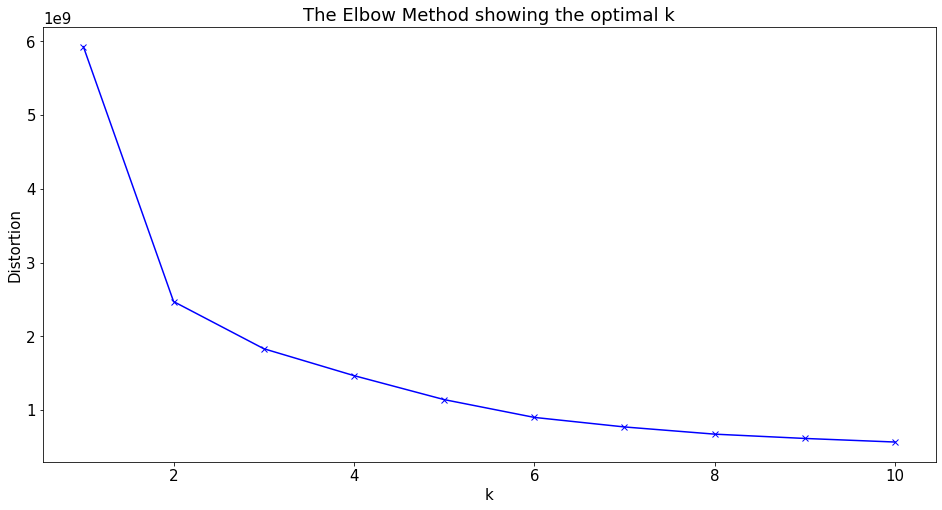

In [117]:
# rs = MachineLearningRecommander(sampled_books)
# mybooks = rs.encodingDataFrame(df=sampled_books,labels=['ISBN','bookTitle','bookAuthor','yearOfPublication','publisher'])
# mybooks = mybooks.drop(columns=['ISBN'])
# distortions = []
# K = range(1,11)
# for k in K:
#     kmeanModel = KMeans(n_clusters=k)
#     kmeanModel.fit(mybooks)
#     distortions.append(kmeanModel.inertia_)

# plt.figure(figsize=(16,8))
# plt.plot(K, distortions, 'bx-')
# plt.xlabel('k')
# plt.ylabel('Distortion')
# plt.title('The Elbow Method showing the optimal k')
# plt.show()

In [118]:
# knn_recommander = MachineLearningRecommander(sampled_books)
# knn_recommander.make_knn()

            ISBN  bookTitle  bookAuthor  yearOfPublication  publisher
0     0440234743       3314         882               1999         82
1     0971880107       3692        1536               2004        396
2     0345417623       3462        1191               2000         34
3     0446310786       3473         639               1988        203
4     0449005615       2216        1051               2002         34
...          ...        ...         ...                ...        ...
3911  0373077742        709         395               1997        360
3912  156414450X       1111         788               2001         60
3913  0671683551       3595        1625               1989        113
3914  0746016719        977        1478               1995        102
3915  088743973X       2528         745               1998        349

[3916 rows x 5 columns]


In [119]:
# #print(sampled_books.head())
# #'Seabiscuit: An American Legend','LAURA HILLENBRAND',1988,'Little Brown &; Company'


# #knn_recommander.predict_book(suggestion_count=10)

# #knn_recommander.predict_all_test_book(suggestion_count=10)

# knn_recommander.calculate_accuracy_score(suggestion_count=10)

Recommendations for ['0446526614' 'Talking to Addison' 'Jenny Colgan' 2002 'Warner Books'] in cluster [1]:

1 .  ['044023722X' 'A Painted House' 'John Grisham' 2001
 'Dell Publishing Company']
2 .  ['050552497X' 'The Last Male Virgin' 'Katherine Deauxville' 2002
 'Love Spell']
3 .  ['0399136487' 'Damia (Rowan)' 'Anne McCaffrey' 1992 'Putnam Pub Group']
4 .  ['0804111359' 'Secret History' 'DONNA TARTT' 1993 'Ballantine Books']
5 .  ['0393307050' 'Master and Commander (Aubrey-Maturin (Paperback))'
 "Patrick O'Brian" 1990 'W. W. Norton &; Company']
6 .  ['0892967307' 'The Red Room' 'Nicci French' 2001 'Mysterious Press']
7 .  ['0880386525'
 'The Dragonlance Chronicles/Dragons of Autumn Twilight/Dragons of Winter Night/Dragons of Spring Dawning (Collectors Edition)'
 'Margaret Weis' 1988 'Wizards of the Coast']
8 .  ['1551667371' 'Thicker Than Water' 'Maggie Shayne' 2003 'Mira Books']
9 .  ['0553292455' 'Servant of the Empire' 'RAYMOND FEIST' 1997 'Bantam']
10 .  ['0140374248' 'James and t

2 .  ['0671793535'
 "A Rose For Her Grave &amp; Other True Cases (Ann Rule's Crime Files)"
 'Ann Rule' 1993 'Pocket']
3 .  ['0380789353' 'To Catch an Heiress' 'Julia Quinn' 2002 'Avon']
4 .  ['0385722435' 'Ella Minnow Pea: A Novel in Letters' 'Mark Dunn' 2002
 'Anchor Books/Doubleday']
5 .  ['0743427149' 'The Twentieth Wife: A Novel' 'Indu Sundaresan' 2002 'Atria']
6 .  ['044020352X'
 'Anguished English: An Anthology of Accidental Assaults Upon Our Language'
 'RICHARD LEDERER' 1989 'Laurel']
7 .  ['0842329218'
 'Tribulation Force: The Continuing Drama of Those Left Behind (Left Behind No. 2)'
 'Tim LaHaye' 1997 'Tyndale House Publishers']
8 .  ['0380400634' 'The Enchanted Land' 'Jude Deveraux' 1978 'Avon']
9 .  ['0552143243' 'The Discworld Mapp' 'Terry Pratchett' 1995 'Corgi']
10 .  ['0440168724' 'A Perfect Stranger' 'Danielle Steel' 1983 'Dell']
__________________________________________________________________________________________________________
Recommendations for ['0684804522' 


1 .  ['0380756234' 'Night Storm' 'Catherine Coulter' 1990 'Avon']
2 .  ['0804119716' 'Out of Control' 'Suzanne Brockmann' 2002 'Ballantine Books']
3 .  ['0688156142' 'The Forgotten: A Peter Decker/Rina Lazarus Novel'
 'Faye Kellerman' 2001 'William Morrow &; Company']
4 .  ['0061097861' 'Hunting Badger (Joe Leaphorn/Jim Chee Novels)'
 'Tony Hillerman' 2000 'HarperCollins']
5 .  ['0425120279' 'The Hunt for Red October' 'Tom Clancy' 1990
 'Berkley Publishing Group']
6 .  ['0671741403' "The Captain's Honor (Star Trek The Next Generation, No 8)"
 'David Dvorkin' 1991 'Star Trek']
7 .  ['0671733893' 'Q-In-Law (Star Trek The Next Generation, No 18)'
 'Peter David' 1991 'Star Trek']
8 .  ['0804118558' 'A Breach of Promise (William Monk Novels (Paperback))'
 'Anne Perry' 1999 'Ivy Books']
9 .  ['0553583441' 'Touching Evil' 'Kay Hooper' 2001 'Bantam Books']
10 .  ['0373484100' 'Night Tales' 'Nora Roberts' 2000 'Silhouette']
______________________________________________________________________

9 .  ['038079456X' "Devil's Bride (Cynster Novels)" 'Stephanie Laurens' 1999
 'Avon']
10 .  ['0671006614' 'TEARS OF RAGE' 'John Walsh' 1997 'Atria']
__________________________________________________________________________________________________________
Recommendations for ['0330292390' 'The Cats of Seroster (Piccolo Books)' 'Robert Westall' 1995
 'Macmillan Pub Ltd'] in cluster [1]:

1 .  ['0451525426'
 'Arabian Nights: The Marvels and Wonders of the Thousand and One Nights'
 'Jack Zipes' 1991 'Signet Classics']
2 .  ['0312306326' 'Visions of Sugar Plums' 'Janet Evanovich' 2002
 "St. Martin's Press"]
3 .  ['0064407691'
 'The Miserable Mill (A Series of Unfortunate Events, Book 4)'
 'Lemony Snicket' 2000 'HarperCollins']
4 .  ['0679821481' 'Six by Seuss: A Treasury of Dr. Seuss Classics' 'Seuss'
 1991 "Random House Children's Books"]
5 .  ['0394900014'
 'Cat in the Hat (I Can Read It All by Myself Beginner Books)' 'Seuss'
 1957 'Random House Books for Young Readers']
6 .  ['038071701

9 .  ['0060959037' 'Prodigal Summer: A Novel' 'Barbara Kingsolver' 2001
 'Perennial']
10 .  ['0345324412' 'Have Spacesuit-Will Travel' 'ROBERT A. HEINLEIN' 1985
 'Del Rey']
__________________________________________________________________________________________________________
Recommendations for ['0688156134'
 'Stalker: A Novel (Peter Decker &amp; Rina Lazarus Novels (Hardcover))'
 'Faye Kellerman' 2000 'William Morrow &; Company'] in cluster [1]:

1 .  ['0553234609' 'Dragonsong' 'Anne McCaffrey' 1977 'Bantam Books']
2 .  ['0684859734' 'Grave Secrets (Temperance Brennan Novel (Hardcover))'
 'Kathy Reichs' 2002 'Scribner']
3 .  ['0385495404'
 'The First American: The Life and Times of Benjamin Franklin'
 'H. W. Brands' 2002 'Anchor Books/Doubleday']
4 .  ['0425179613' "It's Not About the Bike: My Journey Back to Life"
 'Lance Armstrong' 2001 'Berkley Publishing Group']
5 .  ['1400040752' 'Black Maps' 'PETER SPIEGELMAN' 2003 'Knopf']
6 .  ['0671729454' 'If There Be Thorns (Dollangange


1 .  ['0553802496' 'Odd Thomas' 'Dean Koontz' 2003 'Bantam']
2 .  ['0142001740' 'The Secret Life of Bees' 'Sue Monk Kidd' 2003
 'Penguin Books']
3 .  ['0140293248' "The Girls' Guide to Hunting and Fishing" 'Melissa Bank'
 2000 'Penguin Books']
4 .  ['0684195305' 'CRUEL AND UNUSUAL' 'Patricia Cornwell' 1993 'Scribner']
5 .  ['0515114693' 'Born in Fire' 'Nora Roberts' 1994 'Jove Books']
6 .  ['0812694333' "The Simpsons and Philosophy: The D'oh! of Homer"
 'William Irwin' 2001 'Open Court Publishing Company']
7 .  ['0345433084' 'The Syndrome : A Thriller' 'John Case' 2001
 'Ballantine Books']
8 .  ['0440217032' 'Desired' 'Virginia Henley' 1998 'Island']
9 .  ['0446670251' 'The Virgin Suicides' 'Jeffrey Eugenides' 1994
 'Warner Books']
10 .  ['0553131893' 'Dragondrums' 'Anne McCaffrey' 1980 'Bantam Books']
__________________________________________________________________________________________________________
Recommendations for ['0552143243' 'The Discworld Mapp' 'Terry Pratchett' 1995 


1 .  ['0156006847' 'The Fencing Master: A Novel' 'Arturo PÃ©rez-Reverte' 2000
 'Harvest Books']
2 .  ['0446513342' "The Sidetracked Sisters' Happiness File" 'Pam Young' 1985
 'Warner Books']
3 .  ['0373711158' 'The Inn at Oak Creek' 'Linda Barrett' 2003 'Harlequin']
4 .  ['0553576801' 'The Perfect Husband' 'LISA GARDNER' 1997 'Bantam']
5 .  ['0671024108' 'Speaking in Tongues' 'Jeffery Deaver' 2002 'Pocket']
6 .  ['0312282990' 'The Amazing Adventures of Kavalier &amp; Clay'
 'Michael Chabon' 2001 'Picador']
7 .  ['0451200152' 'The Town' 'Bentley Little' 2000 'Signet Book']
8 .  ['0449904962'
 'Indian Givers: How the Indians of the Americas Transformed the World'
 'Jack Weatherford' 1990 'Ballantine Books']
9 .  ['0156787334' "A Room of One's Own" 'Virginia Woolf' 1989 'Harcourt']
10 .  ['0373250231' 'Spanish Disco (Red Dress Ink (Paperback))' 'Erica Orloff'
 2003 'Red Dress Ink']
__________________________________________________________________________________________________________


10 .  ['0060175400' 'The Poisonwood Bible' 'Barbara Kingsolver' 1999
 'HarperCollins']
__________________________________________________________________________________________________________
Recommendations for ['055357227X' 'The Web (Alex Delaware Series, No. 10)'
 'JONATHAN KELLERMAN' 1996 'Bantam'] in cluster [1]:

1 .  ['0373093276' 'Almost Forever' 'Linda Howard' 1986 'Silhouette']
2 .  ['0553579754' 'Fear Nothing' 'DEAN KOONTZ' 1998 'Bantam']
3 .  ['0671036645'
 'LA Connections : Power, Obsession, Murder, Revenge (L.A. Connections)'
 'Jackie Collins' 1999 'Pocket']
4 .  ['0394558235' 'Queen of the Damned (Vampire Chronicles, Book III)'
 'Anne Rice' 1988 'Alfred A. Knopf']
5 .  ['0886775981'
 'To Green Angel Tower, Part 1 (Memory, Sorrow, and Thorn, Book 3)'
 'Tad Williams' 1994 'Daw Books']
6 .  ['0440223237' 'Malice' 'DANIELLE STEEL' 1997 'Dell']
7 .  ['0385416342' 'The Firm' 'John Grisham' 1991 'Doubleday Books']
8 .  ['034530988X' 'Friday' 'Robert Heinlein' 1988 'Del Rey Bo

2 .  ['0553587188' "Lucky's Lady" 'TAMI HOAG' 2003 'Bantam']
3 .  ['0812504798' 'The Red Badge of Courage' 'Stephen Crane' 1997 'Tor Books']
4 .  ['0440126894' 'Full Circle' 'Danielle Steel' 1985 'Dell']
5 .  ['0449003183'
 'Brunswick Gardens (Charlotte &amp; Thomas Pitt Novels (Paperback))'
 'Anne Perry' 1999 'Fawcett Books']
6 .  ['0140366784' 'Jane Eyre (Puffin Classics)' 'Charlotte Bronte' 1995
 'Puffin Books']
7 .  ['0812534867' 'Roc and a Hard Place' 'Piers Anthony' 1996 'Tor Fantasy']
8 .  ['0380722704' 'Charms for Easy Life' 'Kaye Gibbons' 1994 'Avon']
9 .  ['0671670069' 'Guardian Angel' 'Julie Garwood' 1990 'Pocket']
10 .  ['0440484332' 'Superfudge (Yearling Books (Paperback))' 'Judy Blume' 1981
 'Yearling Books']
__________________________________________________________________________________________________________
Recommendations for ['0778320448' 'The Shop On Blossom Street' 'Debbie Macomber' 2004 'Mira'] in cluster [1]:

1 .  ['044021145X' 'The Firm' 'John Grisham' 1992


1 .  ['0671042750' 'A Perfect Spy' 'John le Carre' 2000 'Pocket']
2 .  ['0060092645' 'My Favorite Bride' 'Christina Dodd' 2002 'Avon']
3 .  ['0553579983' 'And Then You Die' 'Iris Johansen' 1998 'Bantam']
4 .  ['0836221362' "It's A Magical World: A Calvin and Hobbes Collection"
 'Bill Watterson' 1996 'Andrews McMeel Publishing']
5 .  ['0060002492' 'Amazonia' 'James Rollins' 2003 'Avon Books']
6 .  ['0892967641' 'Slow Dollar (Deborah Knott Mysteries (Hardcover))'
 'Margaret Maron' 2002 'Mysterious Press']
7 .  ['0440416655' 'A Straw for Two (Ink Drinker)' 'ERIC SANVOISIN' 2003
 'Yearling']
8 .  ['0446608602' 'Personal Injuries' 'Scott Turow' 2000 'Warner Vision']
9 .  ['0393309762' 'Against Forgetting: Twentieth-Century Poetry of Witness'
 'Carolyn Forche' 1993 'W. W. Norton &; Company']
10 .  ['0380731851' 'Mystic River' 'Dennis Lehane' 2002 'HarperTorch']
__________________________________________________________________________________________________________
Recommendations for ['03

3 .  ['0590443518' "Help! I'm a Prisoner in the Library" 'Eth Clifford' 1991
 'Scholastic']
4 .  ['0553560220' 'Illusion' 'Paula Volsky' 1993 'Bantam Books']
5 .  ['0385420161'
 'Like Water for Chocolate: A Novel in Monthly Installments, With Recipes, Romances, and Home Remedies'
 'Laura Esquivel' 1992 'Doubleday Books']
6 .  ['0451173139' 'Night over Water' 'Ken Follett' 1992 'Signet Book']
7 .  ['0345380371' 'Rising Sun' 'MICHAEL CRICHTON' 1992 'Ballantine Books']
8 .  ['0880381744' 'Dragons of Winter Night' 'Margaret Weis' 1985
 'Wizards of the Coast']
9 .  ['0553576801' 'The Perfect Husband' 'LISA GARDNER' 1997 'Bantam']
10 .  ['1401300014'
 "The Essential 55: An Award-Winning Educator's Rules for Discovering the Successful Student in Every Child"
 'Ron Clark' 2003 'Hyperion']
__________________________________________________________________________________________________________
Recommendations for ['0373239963' 'Waiting For Nick (Silhouette Special Edition)'
 'Nora Roberts' 200

6 .  ['0399151451' 'Bad Business' 'Robert B. Parker' 2004
 'Putnam Publishing Group']
7 .  ['0345368932' 'All the Weyrs of Pern (Dragonriders of Pern (Paperback))'
 'Anne McCaffrey' 1992 'Del Rey Books']
8 .  ['0380818647' "The Devil's Bargain" 'Edith Layton' 2002 'HarperTorch']
9 .  ['0440235782' 'My Spy' 'CHRISTINA SKYE' 2002 'Dell']
10 .  ['0689812361' 'Running Out of Time (Aladdin Fiction)'
 'Margaret Peterson Haddix' 1997 'Aladdin']
__________________________________________________________________________________________________________
Recommendations for ['0440214114' 'Mixed Blessings' 'DANIELLE STEEL' 1993 'Dell'] in cluster [1]:

1 .  ['0671744208' 'Castles' 'Julie Garwood' 1993 'Pocket']
2 .  ['014131088X' 'Speak' 'Laurie Halse Anderson' 2001 'Speak']
3 .  ['0141001771' 'Welcome to My Planet: Where English Is Sometimes Spoken'
 'Shannon Olson' 2001 'Penguin Books']
4 .  ['0440474566' 'Ribsy' 'Beverly Cleary' 1982 'Yearling Books']
5 .  ['014038572X' 'The Outsiders (Now in Sp

2 .  ['0679720200' 'The Stranger' 'ALBERT CAMUS' 1989 'Vintage']
3 .  ['0380815265' 'The Seduction of Sara (Avon Romance)' 'Karen Hawkins' 2001
 'Avon']
4 .  ['0060973277' 'The Mambo Kings Play Songs of Love' 'Oscar Hijuelos' 1990
 'Perennial']
5 .  ['0060915153' 'Why Do Clocks Run Clockwise?' 'David Feldman' 1988
 'Perennial']
6 .  ['0375413081' 'True Notebooks (Alex Awards (Awards))' 'MARK SALZMAN' 2003
 'Knopf']
7 .  ['0439136369' 'Harry Potter and the Prisoner of Azkaban (Book 3)'
 'J. K. Rowling' 2001 'Scholastic']
8 .  ['0425190641'
 'Fire Ice: A Novel from the Numa Files (Kurt Austin Adventures (Paperback))'
 'Clive Cussler' 2003 'Berkley Publishing Group']
9 .  ['0006547613' 'Involved' 'Kate Oriordan' 1994 'Flamingo']
10 .  ['0743525868' 'Riding the Bullet' 'Stephen King' 2002 'Audioworks']
__________________________________________________________________________________________________________
Recommendations for ['0836210263' 'Still Pumped From Using The Mouse' 'Scott Adams'

4 .  ['074321689X' 'Call Me Crazy : A Memoir (Lisa Drew Books (Hardcover))'
 'Anne Heche' 2001 'Scribner']
5 .  ['0671013963' 'Into the Void (Star Trek New Frontier, No 2)' 'Peter David'
 1997 'Star Trek']
6 .  ['0385720106' 'A Map of the World' 'Jane Hamilton' 1999
 'Anchor Books/Doubleday']
7 .  ['0374110131' 'Being Dead' 'Jim Crace' 2000 'Farrar Straus Giroux']
8 .  ['0064471063' 'The Horse and His Boy' 'C. S. Lewis' 1994 'HarperCollins']
9 .  ['0963784617' 'Quietus' 'Vivian Schilling' 2002 'Hannover House USA']
10 .  ['1578400619' 'Typee (Classics Illustrated)' 'Herman Miller' 1997
 'Acclaim Books']
__________________________________________________________________________________________________________
Recommendations for ['0060175184' 'The Fourth Estate' 'Jeffrey Archer' 1996 'Harpercollins'] in cluster [1]:

1 .  ['067172519X' 'RAISE THE TITANIC (Clive Cussler)' 'Clive Cussler' 1990
 'Pocket']
2 .  ['069401236X' 'A Little Princess (Book and Charm)'
 'Frances Hodgson Burnett' 19

1 .  ['0767908171' 'A Short History of Nearly Everything' 'Bill Bryson' 2003
 'Broadway']
2 .  ['0140502076' "Madeline's Rescue: Story and Pictures (Picture Puffin)"
 'Ludwig Bemelmans' 1977 'Puffin Books']
3 .  ['0441002935' 'The Lunatic Cafe (Anita Blake Vampire Hunter (Paperback))'
 'Laurell K. Hamilton' 2001 'ACE Charter']
4 .  ['0440200989' 'Weep No More My Lady' 'Mary Higgins Clark' 1993 'Dell']
5 .  ['0886774039' "Sun-Runner's Fire (Dragon Prince, Book 3)" 'Melanie Rawn'
 1994 'Daw Books']
6 .  ['0385306032' 'Vanished' 'Danielle Steel' 1993 'Delacorte Press']
7 .  ['0441005837' 'Rose Daughter' 'Robin McKinley' 1998 'Ace Books']
8 .  ['0446527793' 'The Guardian' 'Nicholas Sparks' 2003 'Warner Books']
9 .  ['0061031321' 'Thief of Time' 'Terry Pratchett' 2002 'HarperTorch']
10 .  ['0449208346' 'Just Wait Till You Have Children of Your Own'
 'Erma Bombeck' 1999 'Fawcett Books']
__________________________________________________________________________________________________________


1 .  ['0688171621' 'Naked Pictures of Famous People' 'Jon Stewart' 1999
 'Perennial Currents']
2 .  ['0345423879' 'Candy' 'Luke Davies' 1998 'Ballantine Books']
3 .  ['0345456521' 'No Graves As Yet: A Novel of World War I' 'Anne Perry' 2003
 'Ballantine Books']
4 .  ['0006550789' '253' 'Geoff Ryman' 1994 'Flamingo']
5 .  ['0425129586' 'And Then There Were None' 'Agatha Christie' 1995
 'Berkley Publishing Group']
6 .  ['0743467523' 'Dreamcatcher' 'Stephen King' 2003 'Pocket']
7 .  ['0887308589'
 "The Dilbert Principle: A Cubicle's-Eye View of Bosses, Meetings, Management Fads &amp; Other Workplace Afflictions"
 'Scott Adams' 1997 'HarperBusiness']
8 .  ['0425189465' 'Chocolate Quake' 'Nancy Fairbanks' 2003
 'Berkley Publishing Group']
9 .  ['0060536705' 'Who Will Take This Man?' "Jacquie D'Alessandro" 2003 'Avon']
10 .  ['0553295772' 'Extreme Measures' 'Michael Palmer' 1992 'Bantam Books']
_________________________________________________________________________________________________

2 .  ['0307126455' "Disney's Beauty and the Beast (Golden Look-Look Book)"
 'Michael Teitelbaum' 1991 'Random House Childrens Books']
3 .  ['0451410157' 'Sweet Nothings' 'Catherine Anderson' 2002 'Onyx Books']
4 .  ['0515122734' 'Sanctuary' 'Nora Roberts' 2004 'Jove Books']
5 .  ['0060934719' 'stardust' 'Neil Gaiman' 2001 'Perennial']
6 .  ['0375703055' 'Ellen Foster' 'Kaye Gibbons' 1997 'Vintage Books']
7 .  ['0345327861' 'Crystal Singer' 'Anne McCaffrey' 1982 'Del Rey Books']
8 .  ['0515135216' 'Dark Symphony' 'Christine Feehan' 2003 'Jove Books']
9 .  ['055323370X' 'Emily of New Moon' 'L.M. MONTGOMERY' 1983 'Laurel Leaf']
10 .  ['0440314887' 'Coming of Age in Mississippi' 'Anne Moody' 1997
 'Laurel Editions']
__________________________________________________________________________________________________________
Recommendations for ['0804118310' 'The House of Forgetting' 'Benjamin Alire Saenz' 1999
 'HarperCollins Publishers'] in cluster [1]:

1 .  ['0446527785' 'A Bend in the Roa

1 .  ['0061010871' 'A Brace of Bloodhounds (Bloodhound (Paperback))'
 'Virginia Lanier' 1998 'HarperTorch']
2 .  ['0399137769' 'Driving Force' 'Dick Francis' 1992 'Putnam Pub Group']
3 .  ['0670894605' 'The Secret Life of Bees' 'Sue Monk Kidd' 2002
 'Viking Books']
4 .  ['0618002243' 'The Return of the King (The Lord of The Rings, Part 3)'
 'J. R. R. Tolkien' 1999 'Houghton Mifflin Company']
5 .  ['050552533X' 'Traveler (Wildside Romance)' 'Melanie Jackson' 2003
 'Love Spell']
6 .  ['0385721234' 'Como Agua Para Chocolate/Like Water for Chocolate'
 'Laura Esquivel' 2001 'Anchor Books/Doubleday']
7 .  ['0345318854'
 'With a Tangled Skein (Incarnations of Immortality (Paperback))'
 'PIERS ANTHONY' 1986 'Del Rey']
8 .  ['0618002235' 'The Two Towers (The Lord of the Rings, Part 2)'
 'J. R. R. Tolkien' 1999 'Houghton Mifflin Company']
9 .  ['0515126772' 'Jewels of the Sun (Irish Trilogy)' 'Nora Roberts' 2004
 'Jove Books']
10 .  ['0380709120' 'Henry Huggins (50th Anniversary Edition)' 'Bever

3 .  ['0671020374' 'Fire on High (Star Trek New Frontier, No 6)' 'Peter David'
 1998 'Star Trek']
4 .  ['0446531588' 'Derailed' 'James Siegel' 2003 'Warner Books']
5 .  ['0399141146' 'The Hundred Secret Senses' 'Amy Tan' 1995
 'Putnam Pub Group']
6 .  ['006016848X'
 'Men Are from Mars, Women Are from Venus: A Practical Guide for Improving Communication and Getting What You Want in Your Relationships'
 'John Gray' 1992 'HarperCollins Publishers']
7 .  ['0740734377' 'Pearls Before Swine : BLTs Taste So Darn Good'
 'Stephan Pastis' 2003 'Andrews McMeel Publishing']
8 .  ['0670030643' 'The Eyre Affair (Alex Awards (Awards))' 'Jasper Fforde'
 2002 'Viking Books']
9 .  ['0671020293' 'Butterfly (Orphans)' 'V.C. Andrews' 1998 'Pocket']
10 .  ['0345420438' 'The Tailor of Panama' 'John Le Carre' 1997
 'Ballantine Books']
__________________________________________________________________________________________________________
Recommendations for ['0590443518' "Help! I'm a Prisoner in the Library

5 .  ['051511054X' 'Bygones' 'LaVyrle Spencer' 1996 'Jove Books']
6 .  ['0553261738' 'You Can Get There from Here' 'Shirley MacLaine' 1976
 'Bantam Books']
7 .  ['0399148817' 'Sleep No More' 'Greg Iles' 2002 'Putnam Adult']
8 .  ['0515121207' 'Proof' 'Dick Francis' 1997 'Jove Books']
9 .  ['0345378490' 'Congo' 'Michael Crichton' 1995 'Ballantine Books']
10 .  ['0425184056' 'Gunpowder Green' 'Laura Childs' 2002
 'Berkley Publishing Group']
__________________________________________________________________________________________________________
Recommendations for ['0380784157' 'Competitions : Book Two of The Blending (Competitions)'
 'Sharon Green' 1997 'Eos'] in cluster [1]:

1 .  ['0671027573' 'Mr. Perfect' 'Linda Howard' 2001 'Pocket Star']
2 .  ['059045367X' 'Monster Blood (Goosebumps, No 3)' 'R. L. Stine' 1995
 'Scholastic']
3 .  ['039914210X' 'The Cat Who Tailed a Thief' 'Lilian Jackson Braun' 1997
 'Putnam Pub Group']
4 .  ['0399147357' 'Dead Sleep' 'Greg Iles' 2001 "G. P. Putna

9 .  ['0679732268'
 'Light in August: The Corrected Text (Vintage International)'
 'William Faulkner' 1991 'Vintage Books USA']
10 .  ['0374153248' 'Family Man' 'Calvin Trillin' 1998 'Farrar Straus &; Giroux']
__________________________________________________________________________________________________________
Recommendations for ['0060083263' 'Sleeping Beauty (Margolin, Phillip)' 'Phillip Margolin'
 2004 'HarperCollins'] in cluster [1]:

1 .  ['0440236991' 'Leap of Faith' 'Danielle Steel' 2002
 'Dell Publishing Company']
2 .  ['1551666758' 'The Perfect Lie' 'Dinah Mccall' 2003 'Mira']
3 .  ['0525444440' 'The House at Pooh Corner' 'Alan Alexander Milne' 1988
 'Dutton Books']
4 .  ['0451179188' 'Throat' 'Peter Straub' 1999 'Signet Book']
5 .  ['0880389117' 'Flint the King (Dragonlance: Preludes)' 'Mary Kirchoff'
 1990 'Wizards of the Coast']
6 .  ['044652087X' 'My Sergei: A Love Story' 'Ekaterina Gordeeva' 1996
 'Warner Books']
7 .  ['055380300X' 'Sense of Evil' 'KAY HOOPER' 2003 '


1 .  ['0006550789' '253' 'Geoff Ryman' 1994 'Flamingo']
2 .  ['0688171621' 'Naked Pictures of Famous People' 'Jon Stewart' 1999
 'Perennial Currents']
3 .  ['0312971125' 'Crazy for You' 'Jennifer Crusie' 2000 "St. Martin's Press"]
4 .  ['0887308589'
 "The Dilbert Principle: A Cubicle's-Eye View of Bosses, Meetings, Management Fads &amp; Other Workplace Afflictions"
 'Scott Adams' 1997 'HarperBusiness']
5 .  ['0345456521' 'No Graves As Yet: A Novel of World War I' 'Anne Perry' 2003
 'Ballantine Books']
6 .  ['0060191988' 'A Night Without Armor : Poems' 'Jewel' 1998 'HarperCollins']
7 .  ['0505525526' 'Single White Vampire' 'Lynsay Sands' 2003 'Love Spell']
8 .  ['0929634063' '50 Simple Things You Can Do to Save the Earth'
 'Earthworks Group' 1989 'Pub Group West']
9 .  ['0743467523' 'Dreamcatcher' 'Stephen King' 2003 'Pocket']
10 .  ['0671697994' 'Brothers in Arms' 'Lois McMaster Bujold' 1989 'Baen']
______________________________________________________________________________________

3 .  ['0679417796' 'The Alienist' 'Caleb Carr' 1994 'Random House']
4 .  ['0345434803' 'The Vampire Armand (The Vampire Chronicles, Book 6)'
 'Anne Rice' 2000 'Ballantine Books']
5 .  ['0449217264' 'Alaska' 'James A. Michener' 1994 'Fawcett Books']
6 .  ['0671727796' 'The Color Purple' 'Alice Walker' 1990 'Pocket']
7 .  ['0875420036'
 "True Magick: A Beginner's Guide (Llewellyn's New Age Series)" 'K. Amber'
 1991 'Llewellyn Publications']
8 .  ['0380724979'
 'Sanctuary (Peter Decker &amp; Rina Lazarus Novels (Paperback))'
 'Faye Kellerman' 1995 'Avon']
9 .  ['0671025333' 'Empty Promises' 'Ann Rule' 2000 'Pocket']
10 .  ['0758200412' 'Someone Killed His Boyfriend' 'David Stukas' 2002
 'Kensington Publishing Corporation']
__________________________________________________________________________________________________________
Recommendations for ['067082982X' 'The Dark Half' 'Stephen King' 1992 'Viking Books'] in cluster [1]:

1 .  ['0451177037' 'Suspicion of Guilt' 'Barbara Parker' 199

9 .  ['0767903862' 'In a Sunburned Country' 'Bill Bryson' 2001 'Broadway Books']
10 .  ['0345347951' "Childhood's End" 'Arthur C. Clarke' 1987 'Del Rey Books']
__________________________________________________________________________________________________________
Recommendations for ['0345463404' 'The Defiant Hero' 'SUZANNE BROCKMANN' 2003 'Ivy Books'] in cluster [1]:

1 .  ['0385479565' 'The Hot Zone' 'Richard Preston' 1995 'Anchor']
2 .  ['0449205878' 'Poland' 'James A. Michener' 1990 'Fawcett Books']
3 .  ['0767900383' 'Under the Tuscan Sun' 'Frances Mayes' 1997 'Broadway']
4 .  ['1551666189' 'Manhunting (Mira)' 'Jennifer Crusie' 2000 'Mira']
5 .  ['0449211479' 'The Source' 'James A. Michener' 1992 'Fawcett Books']
6 .  ['0451190572' 'The Green Mile: Coffey on the Mile (Green Mile Series)'
 'Stephen King' 1996 'Signet Book']
7 .  ['0345423429' 'A Caress of Twilight (Meredith Gentry Novels (Paperback))'
 'LAURELL K. HAMILTON' 2003 'Fawcett']
8 .  ['0553561189' 'Mistress of the Emp

3 .  ['0688046606' 'Night over Water' 'Ken Follett' 1991
 'Harpercollins Childrens Books']
4 .  ['006440031X' 'The First Four Years (Little House)' 'Laura Ingalls Wilder'
 1953 'HarperTrophy']
5 .  ['0345391772' 'The Bastard Prince (Heirs of Saint Camber)'
 'Katherine Kurtz' 1995 'Del Rey Books']
6 .  ['0394800796' 'How the Grinch Stole Christmas!' 'Dr. Seuss' 1957
 'Random House Books for Young Readers']
7 .  ['0345423879' 'Candy' 'Luke Davies' 1998 'Ballantine Books']
8 .  ['0385498721' 'Survivor : A Novel' 'CHUCK PALAHNIUK' 2000 'Anchor']
9 .  ['0060191988' 'A Night Without Armor : Poems' 'Jewel' 1998 'HarperCollins']
10 .  ['0887308589'
 "The Dilbert Principle: A Cubicle's-Eye View of Bosses, Meetings, Management Fads &amp; Other Workplace Afflictions"
 'Scott Adams' 1997 'HarperBusiness']
__________________________________________________________________________________________________________
Recommendations for ['0373484232' 'Stanislaski Sisters' 'Nora Roberts' 2001 'Silhouette'

5 .  ['0553278029' 'A Great Deliverance' 'Elizabeth George' 1989 'Bantam Books']
6 .  ['0449223612' 'N Is for Noose' 'Sue Grafton' 1999 'Fawcett Books']
7 .  ['0345361571' 'A Book of Angels' 'SOPHY BURNHAM' 1990
 'Wellspring/Ballantine']
8 .  ['0446610399' 'The Rescue' 'Nicholas Sparks' 2001 'Warner Books']
9 .  ['0452282195' 'The Bluest Eye' 'Toni Morrison' 2000 'Plume Books']
10 .  ['0671642561' 'Fallen Hearts' 'V.C. Andrews' 1988 'Pocket']
__________________________________________________________________________________________________________
Recommendations for ['0671873199' 'All That Glitters (Landry)' 'V.C. Andrews' 1995 'Pocket'] in cluster [1]:

1 .  ['067100400X' 'Courting Susannah' 'Linda Lael Miller' 2000 'Pocket']
2 .  ['0451203054' 'Praying for Sleep' 'Jeffrey Deaver' 2001 'Signet Book']
3 .  ['0373243790'
 'Considering Kate (The Stanislaskis) (Silhouette Special Edition)'
 'Nora Roberts' 2001 'Silhouette']
4 .  ['0312265859'
 'Hard Eight : A Stephanie Plum Novel (A Step


1 .  ['0451406869' 'The Rake' 'Mary Jo Putney' 1998 'Topaz']
2 .  ['0671020374' 'Fire on High (Star Trek New Frontier, No 6)' 'Peter David'
 1998 'Star Trek']
3 .  ['0345368959' 'The Dolphins of Pern (Dragonriders of Pern (Paperback))'
 'Anne McCaffrey' 1995 'Del Rey Books']
4 .  ['0515133701' 'The Perfect Victim' 'Linda Castillo' 2002 'Jove Books']
5 .  ['0345350499' 'The Mists of Avalon' 'MARION ZIMMER BRADLEY' 1987 'Del Rey']
6 .  ['0373226411'
 "Lassiter'S Law (43 Light Street/Mine To Keep) (Harlequin Intrigue, No. 641)"
 'Rebecca York' 2001 'Harlequin']
7 .  ['0525945210' 'A Man Named Dave: A Story of Triumph and Forgiveness'
 'David J. Pelzer' 1999 'Dutton Books']
8 .  ['0886773490' 'The Star Scroll (Dragon Prince, Book 2)' 'Melanie Rawn'
 1994 'Daw Books']
9 .  ['0679735771' 'American Psycho (Vintage Contemporaries)'
 'Bret Easton Ellis' 2000 'Vintage Books USA']
10 .  ['0553280147' 'Till We Meet Again' 'Judith Krantz' 1989 'Bantam Books']
______________________________________

10 .  ['0253200016' 'Metamorphoses' 'Ovid' 1955 'Indiana University Press']
__________________________________________________________________________________________________________
Recommendations for ['1551666952' 'The Falls' 'Karen Harper' 2003 'Mira'] in cluster [1]:

1 .  ['0195202198' 'The Classic Fairy Tales' 'Iona Archivald Opie' 1980
 'Oxford University Press']
2 .  ['0717283534' 'Lion King Disney' 'Disney' 1994 'Stoddart+publishing']
3 .  ['0440201926' 'Kaleidoscope' 'Danielle Steel' 1988 'Dell']
4 .  ['0425181685'
 'Narcissus in Chains (Anita Blake Vampire Hunter (Hardcover))'
 'Laurell K. Hamilton' 2001 'Berkley Publishing Group']
5 .  ['0446400157'
 'A Morbid Taste for Bones: The First Chronicle of Brother Cadfael'
 'Ellis Peters' 1994 'Warner Books']
6 .  ['0765342987' "Kushiel's Dart" 'Jacqueline Carey' 2002 'Tor Books']
7 .  ['0553801279' 'A Traitor to Memory' 'Elizabeth George' 2001 'Bantam Books']
8 .  ['0670892963' 'Bridget Jones : The Edge of Reason' 'Helen Fieldin

 'Bantam Dell Pub Group']
2 .  ['0671673688' 'While My Pretty One Sleeps' 'Mary Higgins Clark' 1990
 'Pocket']
3 .  ['0804118310' 'The House of Forgetting' 'Benjamin Alire Saenz' 1999
 'HarperCollins Publishers']
4 .  ['0684804522' 'GARDEN OF EDEN' 'Ernest Hemingway' 1995 'Scribner']
5 .  ['0440176484' 'Secrets' 'DANIELLE STEEL' 1986 'Dell']
6 .  ['051511605X' 'Undue Influence' 'Steven Paul Martini' 1995 'Jove Books']
7 .  ['0312961863'
 'Agatha Raisin and the Murderous Marriage (An Agatha Raisin Mystery)'
 'M. C. Beaton' 1997 "St. Martin's Paperbacks"]
8 .  ['0515121843' 'Sea Swept (Quinn Brothers (Paperback))' 'Nora Roberts' 2001
 'Jove Books']
9 .  ['0375757899' 'A Journal of the Plague Year (Modern Library Classics)'
 'DANIEL DEFOE' 2001 'Modern Library']
10 .  ['0399144803'
 'Three Complete Novels: Daring to Dream/Holding the Dream/Finding the Dream (Dream)'
 'Nora Roberts' 1999 'Putnam Publishing Group']
____________________________________________________________________________


1 .  ['0345335287' 'The Black Unicorn (Magic Kingdom of Landover Novel)'
 'Terry Brooks' 1990 'Del Rey Books']
2 .  ['0307123200'
 "Grover's Book of Cute Things to Touch (Golden Sturdy Shape)"
 'Constance Allen' 1990 'Random House Childrens Books']
3 .  ['0312974256' 'Welcome to Temptation' 'Jennifer Crusie' 2001
 "St. Martin's Paperbacks"]
4 .  ['0316570826' 'The Man in My Basement: A Novel' 'Walter Mosley' 2004
 'Little, Brown']
5 .  ['155166416X' 'Sweet Baby' 'Sharon Sala' 1998 'Mira']
6 .  ['0312955006' 'The Concrete Blonde (A Harry Bosch Novel)'
 'Michael Connelly' 1995 "St. Martin's Paperbacks"]
7 .  ['0802132758' 'Rosencrantz &amp; Guildenstern Are Dead' 'Tom Stoppard'
 1991 'Grove Press']
8 .  ['1558531025'
 "Life's Little Instruction Book (Life's Little Instruction Books (Paperback))"
 'H. Jackson Brown' 1991 'Thomas Nelson']
9 .  ['0553213164'
 'Anne of Windy Poplars (Anne of Green Gables Novels (Paperback))'
 'L.M. MONTGOMERY' 1983 'Bantam Classics']
10 .  ['0590494457' 'Th

7 .  ['0440995779' 'The Witch of Blackbird Pond (Laurel Leaf Books)'
 'ELIZABETH GEORGE SPEARE' 1978 'Laure Leaf']
8 .  ['0893753564' 'Christmas Carol' 'Charles Dickens' 1980
 'Troll Communications']
9 .  ['0060392452'
 'Stupid White Men ...and Other Sorry Excuses for the State of the Nation!'
 'Michael Moore' 2002 'Regan Books']
10 .  ['0451170385' 'Four Past Midnight' 'Stephen King' 2001 'Signet Book']
__________________________________________________________________________________________________________
Recommendations for ['081296683X' "Girls' Poker Night: A Novel" 'Jill Davis' 2003
 'Random House Trade'] in cluster [1]:

1 .  ['0842332251' 'The Mark: The Beast Rules the World (Left Behind #8)'
 'Tim LaHaye' 2000 'Tyndale House Publishers']
2 .  ['0385335482' 'Confessions of a Shopaholic (Summer Display Opportunity)'
 'SOPHIE KINSELLA' 2001 'Delta']
3 .  ['0060191546' 'Life Signs: The Biology of Star Trek' 'Susan Jenkins' 1998
 'HarperCollins Publishers']
4 .  ['0743260244' "Aga

3 .  ['015100692X' 'The Crimson Petal and the White' 'Michel Faber' 2002
 'Harcourt']
4 .  ['0425119661' 'Sisters in Crime 2 (Sisters in Crime)' 'Marilyn Wallace'
 1990 'Berkley Publishing Group']
5 .  ['0060248025' 'Falling Up' 'Shel Silverstein' 1996 'HarperCollins']
6 .  ['0425109720' 'Patriot Games (Jack Ryan Novels)' 'Tom Clancy' 1992
 'Berkley Publishing Group']
7 .  ['0312289723' 'Ten Big Ones: A Stephanie Plum Novel' 'Janet Evanovich'
 2004 "St. Martin's Press"]
8 .  ['0064408639'
 'The Austere Academy (A Series of Unfortunate Events, Book 5)'
 'Lemony Snicket' 2000 'HarperCollins']
9 .  ['0439136350' 'Harry Potter and the Prisoner of Azkaban (Book 3)'
 'J. K. Rowling' 1999 'Scholastic']
10 .  ['0140019502' 'La Symphonie Pastorale Isabelle' 'Andre Gide' 1994
 'Penguin Putnam~trade']
__________________________________________________________________________________________________________
Recommendations for ['0373226985' 'Heir to Secret Memories  (Top Secret Babies)'
 'Mallory 

6 .  ['0671737821' "Honor's Splendour" 'Julie Garwood' 1991 'Pocket']
7 .  ['051511054X' 'Bygones' 'LaVyrle Spencer' 1996 'Jove Books']
8 .  ['0679785892'
 'Fear and Loathing in Las Vegas : A Savage Journey to the Heart of the American Dream'
 'HUNTER S. THOMPSON' 1998 'Vintage Books']
9 .  ['0446364193' 'Along Came a Spider (Alex Cross Novels)' 'James Patterson'
 1993 'Warner Books']
10 .  ['0486275426' "The Devil's Dictionary (Dover Thrift Editions)"
 'Ambrose Bierce' 1993 'Dover Publications']
__________________________________________________________________________________________________________
Recommendations for ['0439139600' 'Harry Potter and the Goblet of Fire (Book 4)'
 'J. K. Rowling' 2002 'Scholastic Paperbacks'] in cluster [1]:

1 .  ['0099272687' 'Patchwork Planet Uk Edition' 'Anne Tyler' 1994
 'Trafalgar Square']
2 .  ['0373218435' 'Untamed' 'Nora Roberts' 2003 'Silhouette']
3 .  ['0440186560' 'To Love Again' 'Danielle Steel' 1981 'Dell']
4 .  ['0761537295' "The Sims: 

1 .  ['0743467426' 'I Burn For You' 'Susan Sizemore' 2003 'Pocket Star']
2 .  ['0553275100' "The Butcher's Theater" 'Jonathan Kellerman' 1989
 'Bantam Books']
3 .  ['0671449028' 'Going-To-Bed Book, The' 'Sandra Boynton' 1982
 'Little Simon']
4 .  ['0345368940' 'The Dolphins of Pern' 'Anne McCaffrey' 1994
 'Ballantine Books']
5 .  ['0553801376' 'One Door Away from Heaven' 'Dean R. Koontz' 2001
 'Bantam Books']
6 .  ['1551669161' 'Prescribed Danger (Dr. Rhea Lynch Novels)' 'Gwen Hunter'
 2002 'Mira']
7 .  ['0517577550' 'Dave Barry Turns 40' 'Dave Barry' 1990 'Random House Inc']
8 .  ['0064400034' 'Farmer Boy (Little House)' 'Laura Ingalls Wilder' 1953
 'HarperTrophy']
9 .  ['0836220498' 'Night Of Crash-Test Dummies' 'Gary Larson' 1988
 'Andrews McMeel Publishing']
10 .  ['0425107469' 'Watchers' 'Dean R. Koontz' 1996 'Berkley Publishing Group']
__________________________________________________________________________________________________________
Recommendations for ['0671042564' 'Blac

10 .  ['0812577701'
 'Irish Whiskey: A Nuala Anne McGrail Novel (Nuala Anne McGrail Novels (Paperback))'
 'Andrew M. Greeley' 1998 'Tor Books']
__________________________________________________________________________________________________________
Recommendations for ['0425157539' 'Sudden Prey' 'John Sandford' 1997
 'Berkley Publishing Group'] in cluster [1]:

1 .  ['0743245520' 'Hello, Darkness' 'Sandra Brown' 2003 'Simon &; Schuster']
2 .  ['0373244487' "Cordina's Crown Jewel" 'Nora Roberts' 2002 'Silhouette']
3 .  ['0451202856' 'Nothing but the Truth' 'John T. Lescroart' 2001
 'Signet Book']
4 .  ['0060809833' 'Brave New World' 'Aldous Huxley' 1989 'Harpercollins']
5 .  ['0380732661'
 'The Ritual Bath (Peter Decker &amp; Rina Lazarus Novels (Paperback))'
 'Faye Kellerman' 1999 'Avon']
6 .  ['0439139597' 'Harry Potter and the Goblet of Fire (Book 4)'
 'J. K. Rowling' 2000 'Scholastic']
7 .  ['0312194390'
 'The Autobiography of Henry VIII: With Notes by His Fool, Will Somers : A No

6 .  ['0385492081'
 'Into Thin Air : A Personal Account of the Mt. Everest Disaster'
 'JON KRAKAUER' 1998 'Anchor']
7 .  ['0380816849' 'Dead North: An Alaska Mystery' 'Sue Henry' 2002 'Avon']
8 .  ['0441010512' 'Club Dead (Southern Vampire Mysteries)' 'Charlaine Harris'
 2003 'Ace Books']
9 .  ['0515116068' 'Hidden Riches' 'Nora Roberts' 2004 'Jove Books']
10 .  ['0821769359' 'Hot Rain (Zebra Romantic Suspense)' 'Kat Martin' 2002
 'Kensington Publishing Corporation']
__________________________________________________________________________________________________________
Recommendations for ['0373691114' 'Some Like It Sizzling' 'Jamie Sobrato' 2003 'Harlequin'] in cluster [1]:

1 .  ['0671042858' 'The Girl Who Loved Tom Gordon' 'Stephen King' 2000 'Pocket']
2 .  ['0671870114' 'Saving Grace' 'Julie Garwood' 1994 'Pocket']
3 .  ['0375707972' 'The Reader' 'Bernhard Schlink' 1999 'Vintage Books USA']
4 .  ['0449006344' 'Angel Falls' 'KRISTIN HANNAH' 2001 'Ballantine Books']
5 .  ['0515091


1 .  ['0375411070' 'Basket Case' 'CARL HIAASEN' 2002 'Knopf']
2 .  ['0440416655' 'A Straw for Two (Ink Drinker)' 'ERIC SANVOISIN' 2003
 'Yearling']
3 .  ['0895261537' "What's So Great About America" "Dinesh D'Souza" 2002
 'Regnery Publishing']
4 .  ['0060256672' 'Where the Sidewalk Ends : Poems and Drawings'
 'Shel Silverstein' 1974 'HarperCollins']
5 .  ['0836221362' "It's A Magical World: A Calvin and Hobbes Collection"
 'Bill Watterson' 1996 'Andrews McMeel Publishing']
6 .  ['0671042750' 'A Perfect Spy' 'John le Carre' 2000 'Pocket']
7 .  ['0553579983' 'And Then You Die' 'Iris Johansen' 1998 'Bantam']
8 .  ['0060092645' 'My Favorite Bride' 'Christina Dodd' 2002 'Avon']
9 .  ['0140430024' 'Middlemarch' 'George Eliot' 1987 'Penguin Books']
10 .  ['156076113X' 'The Kinslayer Wars (Dragonlance Elven Nations, vol.2)'
 'Douglas Niles' 1991 'TSR']
__________________________________________________________________________________________________________
Recommendations for ['0843944374' '

8 .  ['0446363073' 'Midnight Graffiti' 'James Van Hise' 1992 'Warner Books']
9 .  ['0446670251' 'The Virgin Suicides' 'Jeffrey Eugenides' 1994
 'Warner Books']
10 .  ['0440217032' 'Desired' 'Virginia Henley' 1998 'Island']
__________________________________________________________________________________________________________
Recommendations for ['0553580000' 'The Tin Man' 'Dale Brown' 1999 'Bantam Books'] in cluster [1]:

1 .  ['0452283442' 'The Darwin Awards: Evolution in Action' 'Wendy Northcutt'
 2002 'Plume Books']
2 .  ['0345435869'
 'The Rivan Codex : Ancient Texts of THE BELGARIAD and THE MALLOREON'
 'DAVID EDDINGS' 1999 'Del Rey']
3 .  ['0743211375' 'From a Buick 8 : A Novel' 'Stephen King' 2002 'Scribner']
4 .  ['0679751521' 'Midnight in the Garden of Good and Evil' 'John Berendt'
 1999 'Vintage Books USA']
5 .  ['0895771462' 'Mysteries of the Unexplained' 'Carroll C. Calkins (Editor)'
 1983 'Putnam Pub Group']
6 .  ['0440226449' 'Freedomland' 'Richard Price' 1999 'Dell Pub

 'Andrews McMeel Publishing']
9 .  ['0446303011' 'A Few Minutes with Andy Rooney' 'Andrew A Rooney' 1982
 'Warner Books> C/o Little Br']
10 .  ['1583224890' '9-11' 'Noam Chomsky' 2001 'Seven Stories Press']
__________________________________________________________________________________________________________
Recommendations for ['0440343194' 'Illusions' 'Richard Bach' 1981 'Bantam Doubleday Dell'] in cluster [1]:

1 .  ['1853261580' 'The Little Prince (Wordsworth Collection)'
 'Antoine de Saint-ExupÃ©ry' 1998 'NTC/Contemporary Publishing Company']
2 .  ['0451152190' 'Over the Edge' 'Jonathan Kellerman' 1993
 'New American Library']
3 .  ['0515133655' 'Tempting' 'Hope Tarr' 2002 'Jove Books']
4 .  ['0553582763' 'By the Light of the Moon' 'DEAN KOONTZ' 2003 'Bantam']
5 .  ['0140314202' 'The Summer of the Swans' 'Betsy Byars' 1996 'Puffin Books']
6 .  ['0525947752' 'The Second Chair: A Novel' 'John T. Lescroart' 2004
 'Dutton Books']
7 .  ['0553575023' 'Charming the Prince' 'TERESA ME

6 .  ['069401236X' 'A Little Princess (Book and Charm)'
 'Frances Hodgson Burnett' 1999 'HarperFestival']
7 .  ['0836217357'
 'Days Are Just Packed : A Calvin and Hobbes Collection (Calvin and Hobbes)'
 'Bill Watterson' 1993 'Andrews McMeel Publishing']
8 .  ['042511774X' 'Breathing Lessons' 'Anne Tyler' 1994
 'Berkley Publishing Group']
9 .  ['1551667967' 'Dead End' 'Helen Myers' 2001 'Mira']
10 .  ['0064471101' "The Magician's Nephew (rack) (Narnia)" 'C. S. Lewis' 2002
 'HarperCollins']
__________________________________________________________________________________________________________
Recommendations for ['0060099453' 'Merry Christmas, Amelia Bedelia (I Can Read Book 2)'
 'Peggy Parish' 2002 'HarperTrophy'] in cluster [1]:

1 .  ['0451457730' 'Stardoc: A Novel (Stardoc (Paperback))' 'S. L. Viehl' 2000
 'Roc']
2 .  ['0679405283' 'The Tale of the Body Thief (Vampire Chronicles)'
 'Anne Rice' 1992 'Alfred A. Knopf']
3 .  ['0375758992' "Don't Let's Go to the Dogs Tonight : An Afri

5 .  ['0345370805' 'How to Make an American Quilt' 'Whitney Otto' 1992
 'Ballantine Books']
6 .  ['0786864400' 'The First Victim' 'Ridley Pearson' 1999 'Hyperion']
7 .  ['0345434803' 'The Vampire Armand (The Vampire Chronicles, Book 6)'
 'Anne Rice' 2000 'Ballantine Books']
8 .  ['0312287984' 'Rashomon Gate' 'I.J. Parker' 2002 "St. Martin's Minotaur"]
9 .  ['0679417796' 'The Alienist' 'Caleb Carr' 1994 'Random House']
10 .  ['0373791003' 'Bordering On Obsession (Harlequin Blaze, 96)'
 'Susan Kearney' 2003 'Harlequin']
__________________________________________________________________________________________________________
Recommendations for ['0060191546' 'Life Signs: The Biology of Star Trek' 'Susan Jenkins' 1998
 'HarperCollins Publishers'] in cluster [1]:

1 .  ['081296683X' "Girls' Poker Night: A Novel" 'Jill Davis' 2003
 'Random House Trade']
2 .  ['0842332251' 'The Mark: The Beast Rules the World (Left Behind #8)'
 'Tim LaHaye' 2000 'Tyndale House Publishers']
3 .  ['0330266454'

6 .  ['0380791021' 'Simply Love' 'Catherine Anderson' 1997 'Avon']
7 .  ['0385315724' 'The Paperboy' 'Pete Dexter' 1996 'Delta']
8 .  ['0515120456' 'The Dark Room' 'Minette Walters' 1997 'Jove Books']
9 .  ['0679429220' 'Midnight in the Garden of Good and Evil: A Savannah Story'
 'John Berendt' 1994 'Random House']
10 .  ['0449005615' 'Seabiscuit: An American Legend' 'LAURA HILLENBRAND' 2002
 'Ballantine Books']
__________________________________________________________________________________________________________
Recommendations for ['0399147853' 'Time and Chance' 'Sharon Kay Penman' 2002
 'Putnam Publishing Group'] in cluster [1]:

1 .  ['0446530077' 'Find Me' "Rosie O'Donnell" 2002 'Warner Books']
2 .  ['0374419302' 'The Eagle of the Ninth' 'Rosemary Sutcliff' 1993
 'Farrar, Straus and Giroux (BYR)']
3 .  ['0395259398' 'Mike Mulligan and His Steam Shovel (Sandpiper Books)'
 'Virginia Lee Burton' 1977 'Houghton Mifflin']
4 .  ['0448095017'
 'The Secret of the Old Clock (Nancy Drew

1 .  ['0671742949' 'UNDER SIEGE' 'Stephen Coonts' 1991 'Pocket']
2 .  ['0451180062' 'Abuse of Power' 'Nancy Taylor Rosenberg' 1997 'Signet Book']
3 .  ['0920668372' 'Love You Forever' 'Robert N. Munsch' 1986
 'Firefly Books Ltd']
4 .  ['0345452364' 'The Edge of Doom' 'AMANDA CROSS' 2002 'Ballantine Books']
5 .  ['0380731851' 'Mystic River' 'Dennis Lehane' 2002 'HarperTorch']
6 .  ['0393309762' 'Against Forgetting: Twentieth-Century Poetry of Witness'
 'Carolyn Forche' 1993 'W. W. Norton &; Company']
7 .  ['0446608602' 'Personal Injuries' 'Scott Turow' 2000 'Warner Vision']
8 .  ['0670030457' 'The Grave Maurice' 'Martha Grimes' 2002 'Viking Books']
9 .  ['0553587188' "Lucky's Lady" 'TAMI HOAG' 2003 'Bantam']
10 .  ['0140019421' 'Jennie' 'Paul Gallico' 1963 'Penguin USA']
__________________________________________________________________________________________________________
Recommendations for ['0451207645' 'The Oath' 'John Lescroart' 2003 'Signet Book'] in cluster [1]:

1 .  ['038081

6 .  ['0330294911' 'Man Who Mistook His Wife for a Hat' 'Oliver Sacks' 1994
 'Pan Books Ltd']
7 .  ['1551668122' 'Night Of The Black Bird' 'Heather Graham' 2001 'Mira']
8 .  ['042518045X' 'Unraveled Sleeve (Needlecraft Mysteries)' 'Monica Ferris'
 2001 'Berkley Publishing Group']
9 .  ['0373218486'
 'Going Home: Unfinished Business/ Island of Flowers/ Mind Over Matter'
 'Nora Roberts' 2002 'Silhouette']
10 .  ['0345379144' 'Zombies of the Gene Pool' 'Sharyn McCrumb' 1996
 'Fawcett Books']
__________________________________________________________________________________________________________
Recommendations for ['0316666009' '1st to Die: A Novel' 'James Patterson' 2001
 'Little Brown and Company'] in cluster [1]:

1 .  ['044022859X' 'Holes (Readers Circle)' 'LOUIS SACHAR' 2001 'Laurel Leaf']
2 .  ['0571081789' 'Bell Jar' 'Sylvia Plath' 1994 'Faber Faber Inc']
3 .  ['0399135995' 'Forgiving' 'Lavyrle Spencer' 1991 'Putnam Pub Group']
4 .  ['0440117437' 'Now and Forever' 'Danielle Steel

1 .  ['0156027321' 'Life of Pi' 'Yann Martel' 2003 'Harvest Books']
2 .  ['0515131229' 'Dance upon the Air (Three Sisters Island Trilogy)'
 'Nora Roberts' 2003 'Jove Books']
3 .  ['0440314887' 'Coming of Age in Mississippi' 'Anne Moody' 1997
 'Laurel Editions']
4 .  ['0375703055' 'Ellen Foster' 'Kaye Gibbons' 1997 'Vintage Books']
5 .  ['0786864400' 'The First Victim' 'Ridley Pearson' 1999 'Hyperion']
6 .  ['0679751521' 'Midnight in the Garden of Good and Evil' 'John Berendt'
 1999 'Vintage Books USA']
7 .  ['0307126455' "Disney's Beauty and the Beast (Golden Look-Look Book)"
 'Michael Teitelbaum' 1991 'Random House Childrens Books']
8 .  ['0451410157' 'Sweet Nothings' 'Catherine Anderson' 2002 'Onyx Books']
9 .  ['0684859300'
 'Change Your Life Without Getting Out of Bed : The Ultimate Nap Book'
 'Sark' 1999 'Fireside']
10 .  ['0345453387' 'Dog Handling' 'CLARE NAYLOR' 2002 'Ballantine Books']
____________________________________________________________________________________________

8 .  ['0553582895' 'Dark Rivers of the Heart' 'DEAN KOONTZ' 2000 'Bantam']
9 .  ['0330269828' 'Vintage Stuff' 'Tom Sharpe' 1997 'Pan Publishing']
10 .  ['0517149257' "The Ultimate Hitchhiker's Guide" 'Douglas Adams' 1996
 'Random House Value Publishing']
__________________________________________________________________________________________________________
Recommendations for ['0399146008' 'Shock' 'Robin Cook' 2001 "G. P. Putnam's Sons"] in cluster [1]:

1 .  ['0380794470' 'Dream a Little Dream' 'Susan Elizabeth Phillips' 1998
 'Avon']
2 .  ['0316602906' 'The Big Bad Wolf: A Novel' 'James Patterson' 2003
 'Little, Brown']
3 .  ['0449211479' 'The Source' 'James A. Michener' 1992 'Fawcett Books']
4 .  ['0373791054'
 'Brief Encounters: Put Your Guy On the Cover (Harlequin Blaze, 101)'
 'Suzanne Forster' 2003 'Harlequin']
5 .  ['0312265867' 'To the Nines: A Stephanie Plum Novel' 'Janet Evanovich'
 2003 "St. Martin's Press"]
6 .  ['0425140032' 'Dragon Tears' 'Dean R. Koontz' 1995
 'Berkl

9 .  ['8432068012'
 'Filomeno, a Mi Pesar (ColecciÃ³n Autores espaÃ±oles e hispanoamericanos)'
 'Gonzalo Torrente Ballester' 1995 'Planeta Pub Corp']
10 .  ['188028443X'
 'The Tumbleweed Murders: A Claire Sharples Botanical Mystery'
 'Rebecca Rothenberg' 2001 'Perseverance Press']
__________________________________________________________________________________________________________
Recommendations for ['0836218221' 'The Authoritative Calvin and Hobbes (Calvin and Hobbes)'
 'Bill Watterson' 1990 'Andrews McMeel Publishing'] in cluster [1]:

1 .  ['0553565915' 'Embraced by the Light' 'Betty J. Eadie' 1994 'Bantam Books']
2 .  ['0380718332' 'All That Remains (Kay Scarpetta Mysteries (Paperback))'
 'Patricia D. Cornwell' 1993 'Avon']
3 .  ['044651747X' 'Puerto Vallarta Squeeze' 'Robert James Waller' 1995
 'Warner Books']
4 .  ['0440217520' 'Tunnel Vision (V.I. Warshawski Novels (Paperback))'
 'Sara Paretsky' 1995 'Dell']
5 .  ['0446611808' 'Envy' 'Sandra Brown' 2002 'Warner Books']
6 .

9 .  ['0671870963' 'Prince Charming' 'Julie Garwood' 1995 'Pocket']
10 .  ['0060931418' 'Their Eyes Were Watching God' 'Zora Neale Hurston' 1998
 'Perennial']
__________________________________________________________________________________________________________
Recommendations for ['0345260791' 'Star wars: From the adventures of Luke Skywalker : a novel'
 'George Lucas' 1976 'Ballantine Books'] in cluster [1]:

1 .  ['0316182540' 'White Oleander : A Novel' 'Janet Fitch' 2001
 'Little, Brown']
2 .  ['0451205448' 'Bubbles Unbound' 'Sarah Strohmeyer' 2002 'Signet Book']
3 .  ['0373218400' 'Table For Two' 'Nora Roberts' 2002 'Silhouette']
4 .  ['0767905180' 'Jemima J: A Novel About Ugly Ducklings and Swans'
 'Jane Green' 2001 'Broadway Books']
5 .  ['0679727272' 'Bend Sinister' 'Vladimir Vladimirovich Nabokov' 1990
 'Vintage Books USA']
6 .  ['1573227889' 'Tipping the Velvet' 'Sarah Waters' 2000 'Riverhead Books']
7 .  ['0451188462' 'Desperation' 'Stephen King' 1997 'Signet Book']
8 . 

9 .  ['0064400050' 'By the Shores of Silver Lake (Little House)'
 'Laura Ingalls Wilder' 1953 'HarperTrophy']
10 .  ['0515131768' "The Texan's Dream (Jove Historical Romance)" 'Jodi Thomas'
 2001 'Jove Books']
__________________________________________________________________________________________________________
Recommendations for ['1560760699' 'Kindred Spirits (Dragonlance: The Meetings Sextet, Vol. 1)'
 'Mark Anthony' 1991 'Wizards of the Coast'] in cluster [1]:

1 .  ['0345468627' 'The Hot Flash Club' 'NANCY THAYER' 2003 'Ballantine Books']
2 .  ['0060930535' 'The Poisonwood Bible: A Novel' 'Barbara Kingsolver' 1999
 'Perennial']
3 .  ['0451457730' 'Stardoc: A Novel (Stardoc (Paperback))' 'S. L. Viehl' 2000
 'Roc']
4 .  ['0440235146' 'A Sudden Change of Heart' 'Barbara Taylor Bradford' 1999
 'Dell Publishing Company']
5 .  ['0399148019' 'The Absence of Nectar' 'Kathy Hepinstall' 2001
 "G. P. Putnam's Sons"]
6 .  ['0679405283' 'The Tale of the Body Thief (Vampire Chronicles)'
 'A

__________________________________________________________________________________________________________
Recommendations for ['0064471047'
 'The Lion, the Witch, and the Wardrobe (The Chronicles of Narnia, Book 2)'
 'C. S. Lewis' 1994 'HarperCollins'] in cluster [1]:

1 .  ['0553565915' 'Embraced by the Light' 'Betty J. Eadie' 1994 'Bantam Books']
2 .  ['0345316002' 'Killashandra' 'Anne McCaffrey' 1993 'Del Rey Books']
3 .  ['0679731148' 'A Year in Provence' 'Peter Mayle' 1991 'Vintage Books USA']
4 .  ['0446611808' 'Envy' 'Sandra Brown' 2002 'Warner Books']
5 .  ['0440228654'
 'Chinese Cinderella: The True Story of an Unwanted Daughter (Laurel-Leaf Books)'
 'Adeline Yen Mah' 2001 'Laurel-Leaf Books']
6 .  ['0786808012' 'Artemis Fowl (Artemis Fowl, Book 1)' 'Eoin Colfer' 2001
 'Miramax Kids']
7 .  ['0373871279' 'Family At Last (Love Inspired (Numbered))'
 'Carolyne Aarsen' 2000 'Steeple Hill']
8 .  ['0812555112' 'Faun &amp; Games (Xanth)' 'Piers Anthony' 1998
 'Tor Fantasy']
9 .  ['0


1 .  ['0684853159' 'The Wasp Factory: A Novel' 'Iain Banks' 1998
 'Simon &; Schuster']
2 .  ['0743211383' 'Dreamcatcher' 'Stephen King' 2001 'Scribner']
3 .  ['0590470884' 'The Watcher' 'Lael Littke' 1994
 'Scholastic Paperbacks (Mm)']
4 .  ['0440216818' 'Daybreak' 'Belva Plain' 1995 'Dell Publishing Company']
5 .  ['084395048X' 'Lair of the Lion' 'Christine Feehan' 2002 'Leisure Books']
6 .  ['0684867621' 'The Girl Who Loved Tom Gordon : A Novel' 'Stephen King'
 1999 'Scribner']
7 .  ['0515102652' 'The Cat Who Talked to Ghosts' 'Lilian Jackson Braun' 1996
 'Jove Books']
8 .  ['0804119708' 'Over the Edge' 'Suzanne Brockmann' 2001 'Ivy Books']
9 .  ['0142004235' "East of Eden (Oprah's Book Club)" 'John Steinbeck' 2003
 'Penguin Books']
10 .  ['0385472943' 'The Runaway Jury' 'JOHN GRISHAM' 1996 'Doubleday']
__________________________________________________________________________________________________________
Recommendations for ['0395689902'
 'The Disheveled Dictionary: A Curious Ca

7 .  ['0743245520' 'Hello, Darkness' 'Sandra Brown' 2003 'Simon &; Schuster']
8 .  ['0312194390'
 'The Autobiography of Henry VIII: With Notes by His Fool, Will Somers : A Novel'
 'Margaret George' 1998 "St. Martin's Press"]
9 .  ['055325698X' 'The Proteus Operation' 'James P. Hogan' 1991
 'Spectra Books']
10 .  ['0553561723' 'Burning Time (April Woo Suspense Novels (Paperback))'
 'LESLIE GLASS' 1995 'Bantam']
__________________________________________________________________________________________________________
Recommendations for ['0425151867' 'Acceptable Risk' 'Robin Cook' 1996
 'Berkley Publishing Group'] in cluster [1]:

1 .  ['0425176088' 'Airport' 'Arthur Hailey' 2000 'Berkley Publishing Group']
2 .  ['0440207622' 'Daddy' 'DANIELLE STEEL' 1990 'Dell']
3 .  ['0679435328' 'The Angel of Darkness' 'Caleb Carr' 1997 'Random House Inc']
4 .  ['0330253603' 'Wilt' 'Tom Sharpe' 1978
 'Pan Books in association with Secker &; Warburg']
5 .  ['043935806X' 'Harry Potter and the Order of t

2 .  ['0307100146'
 "Walt Disney's 101 Dalmatians: Pongo to the Rescue (Golden Super Shape Book)"
 'Justine Korman' 1994 'Random House Childrens Books']
3 .  ['0671795538' 'Perfect' 'Judith McNaught' 1994 'Pocket']
4 .  ['0804110972' 'Sin' 'Josephine Hart' 1993 'Ivy Books']
5 .  ['0425180050'
 "Tom Clancy's Op-Center: Line of Control (Tom Clancy's Op Center (Paperback))"
 'Jeff Rovin' 2001 'Berkley Publishing Group']
6 .  ['0553582135' 'Final Target' 'Iris Johansen' 2002 'Bantam Books']
7 .  ['0446613266' 'Four Blind Mice' 'James Patterson' 2003 'Warner Books']
8 .  ['0440236444' "The Fatima Secret (Whitley Strieber's Hidden Agendas)"
 'Michael Hesemann' 2000 'Dell Publishing Company']
9 .  ['0758203594' 'Wilde Thing' 'Janelle Denison' 2003 'BRAVA']
10 .  ['0373484003' 'Irish Hearts' 'Nora Roberts' 2000 'Silhouette']
__________________________________________________________________________________________________________
Recommendations for ['0345458915' 'The Sinner' 'TESS GERRITSEN' 

5 .  ['0345386108' 'Winter Moon' 'Dean R. Koontz' 1995 'Ballantine Books']
6 .  ['0749399570' 'The Joy Luck Club' 'Amy Tan' 1991 'Vintage']
7 .  ['0836218523' 'The Calvin &amp; Hobbes Lazy Sunday Book' 'Bill Watterson'
 1989 'Andrews McMeel Publishing']
8 .  ['0380803941' 'Grandmother Spider : A Charlie Moon Mystery'
 'James D. Doss' 2001 'Avon']
9 .  ['0385317093' 'Granny Dan' 'DANIELLE STEEL' 1999 'Delacorte Press']
10 .  ['155874424X'
 'Chicken Soup for the Soul at Work (Chicken Soup for the Soul Series (Paper))'
 'Jack Canfield' 1996 'Health Communications']
__________________________________________________________________________________________________________
Recommendations for ['1853260207' 'Jane Eyre (Wordsworth Classics)' 'Charlotte Bronte' 1997
 'NTC/Contemporary Publishing Company'] in cluster [1]:

1 .  ['0743420373'
 "The Millionaire Next Door: The Surprising Secrets of America's Wealthy"
 'Thomas J. Stanley' 2000 'Pocket']
2 .  ['0316284955' "White Oleander : A Novel (

7 .  ['0440404193' "Are You There God?  It's Me, Margaret" 'JUDY BLUME' 1971
 'Yearling']
8 .  ['0886778964' "Valor's Choice (Daw Book Collectors)" 'Tanya Huff' 2000
 'Daw Books']
9 .  ['038070577X' 'Case of the Late Pig' 'Margery Allingham' 1989
 'Harper Mass Market Paperbacks (Mm)']
10 .  ['0553258001' 'The Cider House Rules' 'John Irving' 1986 'Bantam Books']
__________________________________________________________________________________________________________
Recommendations for ['0679734775' 'The House on Mango Street (Vintage Contemporaries)'
 'SANDRA CISNEROS' 1991 'Vintage'] in cluster [1]:

1 .  ['0425188809' 'Watchers' 'Dean R. Koontz' 2003 'Berkley Publishing Group']
2 .  ['0425128164' 'The Voice of the Night' 'Dean R. Koontz' 1996
 'Berkley Publishing Group']
3 .  ['0743454529' "My Sister's Keeper : A Novel (Picoult, Jodi)"
 'Jodi Picoult' 2004 'Atria']
4 .  ['0679767789' 'Lost in Place: Growing Up Absurd in Suburbia'
 'Mark Salzman' 1996 'Vintage Books USA']
5 .  ['044

9 .  ['067100042X' 'Silent Night : A Christmas Suspense Story'
 'Mary Higgins Clark' 1996 'Pocket']
10 .  ['0440110653' 'CRY IN THE NIGHT, A' 'MARY HIGGINS CLARK' 1983 'Dell']
__________________________________________________________________________________________________________
Recommendations for ['1560763361'
 'The Oath and the Measure (Dragonlance: The Meetings Sextet, Vol. 4)'
 'Michael Williams' 1992 'Wizards of the Coast'] in cluster [1]:

1 .  ['0425188809' 'Watchers' 'Dean R. Koontz' 2003 'Berkley Publishing Group']
2 .  ['067172701X' 'Meridian' 'Alice Walker' 1990 'Pocket']
3 .  ['0380002930' 'Watership Down' 'Richard Adams' 1976 'Avon']
4 .  ['0345300971' 'Bishops Heir Kelson 1 (Histories of King Kelson)'
 'Katherine Kurtz' 1985 'Ballantine Books']
5 .  ['0060920084' 'The Lost Continent: Travels in Small-Town America'
 'Bill Bryson' 1990 'Perennial']
6 .  ['0446532452' 'The Wedding' 'Nicholas Sparks' 2003 'Warner Books']
7 .  ['039592720X' 'Interpreter of Maladies' 'Jhump

10 .  ['0140019421' 'Jennie' 'Paul Gallico' 1963 'Penguin USA']
__________________________________________________________________________________________________________
Recommendations for ['0671534718' 'Melody (Logan)' 'V.C. Andrews' 1996 'Pocket'] in cluster [1]:

1 .  ['0451405498' "Anna's Book" 'Ruth Rendell' 1994 'Onyx Books']
2 .  ['0140258795'
 'Longitude: The True Story of a Lone Genius Who Solved the Greatest Scientific Problem of His Time'
 'Dava Sobel' 1996 'Penguin Books']
3 .  ['0515131768' "The Texan's Dream (Jove Historical Romance)" 'Jodi Thomas'
 2001 'Jove Books']
4 .  ['0060511508' 'The Further Observations of Lady Whistledown' 'Julia Quinn'
 2003 'Avon']
5 .  ['0849911389' 'A Gentle Thunder' 'Max Lucado' 1995 'W Publishing Group']
6 .  ['0684853515' 'Hearts In Atlantis : New Fiction' 'Stephen King' 1999
 'Scribner']
7 .  ['0064400050' 'By the Shores of Silver Lake (Little House)'
 'Laura Ingalls Wilder' 1953 'HarperTrophy']
8 .  ['0060198133' 'Five Quarters of the

8 .  ['1558744215'
 'A Cup of Chicken Soup for the Soul (Chicken Soup for the Soul Series (Paper))'
 'Jack Canfield' 1996 'Health Communications']
9 .  ['0226816273'
 'A Manual for Writers of Term Papers, Theses, and Dissertations (Chicago Guides to Writing, Editing, and Publishing)'
 'Kate L. Turabian' 1996 'University of Chicago Press']
10 .  ['1888054557' 'Postmarked Yesteryear: 30 Rare Holiday Postcards'
 'Pamela E. Apkarian-Russell' 2001 'Collectors Press']
__________________________________________________________________________________________________________
Recommendations for ['0312168748' "James Herriot's Animal Stories" 'James Herriot' 1997
 "St. Martin's Press"] in cluster [1]:

1 .  ['0425192024' 'A Garden in the Rain' 'Lynn Kurland' 2003
 'Berkley Publishing Group']
2 .  ['0345335082' 'Dragonquest (Dragonquest)' 'Anne McCaffrey' 1990
 'Del Rey Books']
3 .  ['0439062802' 'The Road to Balinor  (Unicorns of Balinor #1)'
 'Mary Stanton' 1999 'Scholastic']
4 .  ['0393050939'

10 .  ['0679419829' 'Stormy Weather' 'Carl Hiaasen' 1995 'Alfred A. Knopf']
__________________________________________________________________________________________________________
Recommendations for ['0449000869'
 'Ashworth Hall (Charlotte &amp; Thomas Pitt Novels (Paperback))'
 'ANNE PERRY' 1998 'Fawcett'] in cluster [1]:

1 .  ['0451409973' 'Julie and Romeo: A Novel' 'Jeanne Ray' 2001 'Onyx Books']
2 .  ['0451197879' 'Roadwork' 'Richard Bachman' 1999 'Signet Book']
3 .  ['0373270976' 'Night Shield (Intimate Moments, 1027)' 'Nora Roberts' 2000
 'Silhouette']
4 .  ['055321330X' 'The Awakening' 'Kate Chopin' 1985 'Bantam']
5 .  ['0440209633' 'One Wore Blue' 'Heather Graham' 1991
 'Dell Publishing Company']
6 .  ['0345337646' 'The Silent Tower (Windrose Chronicles, Book 1)'
 'Barbara Hambly' 1995 'Del Rey Books']
7 .  ['0671873202' 'Hidden Jewel (Landry)' 'V.C. Andrews' 1995 'Pocket']
8 .  ['0880385979' 'Stormblade: Heroes (Dragonlance Saga Novel: Heroes)'
 'Nancy Berberick' 1988 'Wi

2 .  ['0553273914' 'The House of the Spirits' 'Isabel Allende' 1986
 'Bantam Books']
3 .  ['038542017X'
 'Like Water for Chocolate : A Novel in Monthly Installments with Recipes, Romances, and Home Remedies'
 'LAURA ESQUIVEL' 1995 'Anchor']
4 .  ['0671004549' 'You Belong To Me' 'Mary Higgins Clark' 1999 'Pocket Books']
5 .  ['0440407524' 'Shiloh (Yearling Newbery)' 'Phyllis Reynolds Naylor' 1992
 'Yearling Books']
6 .  ['0345345053' 'A Sand County Almanac (Outdoor Essays &amp; Reflections)'
 'Aldo Leopold' 1990 'Ballantine Books']
7 .  ['0688163769' 'The Mediterranean Kitchen' 'Joyce Goldstein' 1998
 'Morrow Cookbooks']
8 .  ['0385508417' 'Skipping Christmas' 'JOHN GRISHAM' 2002 'Doubleday']
9 .  ['0425150429' 'Time Without End' 'Linda Lael Miller' 1995
 'Berkley Publishing Group']
10 .  ['0345413903' 'The Murder Book' 'Jonathan Kellerman' 2003
 'Ballantine Books']
__________________________________________________________________________________________________________
Recommendations


1 .  ['0451198808' 'South: The Endurance Expedition' 'Ernest Shackleton' 1999
 'Signet Book']
2 .  ['0380799375' 'Baby Love' 'Catherine Anderson' 1999 'Avon']
3 .  ['0330306839' 'Holidays In Hell' 'P J Orourke' 1994 'Pan Books Ltd']
4 .  ['0141001615' 'The Read-Aloud Handbook (Read-Aloud Handbook, 5th ed)'
 'Jim Trelease' 2001 'Penguin USA (Paper)']
5 .  ['0440802458' 'Egypt Game' 'Zilpha Keatley Snyder' 1991
 'Bantam Doubleday Dell Publishing Group']
6 .  ['0761315810' 'Shattering Glass' 'Gail Giles' 2002 'Roaring Brook']
7 .  ['0440208459' 'Burn Marks (V.I. Warshawski Novels (Paperback))'
 'Sara Paretsky' 1991 'Dell']
8 .  ['0743435338' 'Diplomatic Immunity' 'Lois McMaster Bujold' 2002 'Baen']
9 .  ['0553582895' 'Dark Rivers of the Heart' 'DEAN KOONTZ' 2000 'Bantam']
10 .  ['0451180062' 'Abuse of Power' 'Nancy Taylor Rosenberg' 1997 'Signet Book']
__________________________________________________________________________________________________________
Recommendations for ['03808110

7 .  ['0812555104' 'Yon Ill Wind : A Xanth Novel (Xanth)' 'Piers Anthony' 1997
 'Tor Fantasy']
8 .  ['039592720X' 'Interpreter of Maladies' 'Jhumpa Lahiri' 1999
 'Houghton Mifflin Co']
9 .  ['0671896768' 'Crossover (Star Trek: The Next Generation)'
 'Michael Jan Friedman' 1996 'Star Trek']
10 .  ['0345300971' 'Bishops Heir Kelson 1 (Histories of King Kelson)'
 'Katherine Kurtz' 1985 'Ballantine Books']
__________________________________________________________________________________________________________
Recommendations for ['0373441886' 'Wanted: An Interesting Life (Harlequin Flipside)'
 'Bev Katz Rosenbaum' 2004 'Harlequin'] in cluster [1]:

1 .  ['0515134465' 'Bloody Bones (Anita Blake Vampire Hunter (Paperback))'
 'Laurell K. Hamilton' 1996 'Jove Books']
2 .  ['0446394521' 'Daisy Fay and the Miracle Man' 'Fannie Flagg' 1992
 'Warner Books']
3 .  ['0553561723' 'Burning Time (April Woo Suspense Novels (Paperback))'
 'LESLIE GLASS' 1995 'Bantam']
4 .  ['0451209486' 'Killer Hair' 'E

__________________________________________________________________________________________________________
Recommendations for ['067091021X' 'Year of Wonders: A Novel of the Plague' 'Geraldine Brooks'
 2001 'Viking Books'] in cluster [1]:

1 .  ['0380756218' 'Night Shadow' 'Catherine Coulter' 1989 'Avon']
2 .  ['0380710404' 'The Secret of the Indian (Indian in the Cupboard)'
 'Lynne Reid Banks' 1999 'HarperTrophy']
3 .  ['0060987219' 'Polaroids from the Dead' 'Douglas Coupland' 1997
 'Regan Books']
4 .  ['0767908473'
 "The Sorcerer's Companion: A Guide to the Magical World of Harry Potter"
 'ALLAN ZOLA KRONZEK' 2001 'Broadway']
5 .  ['0385496095' 'Traveling Mercies: Some Thoughts on Faith' 'Anne Lamott'
 2000 'Anchor Books/Doubleday']
6 .  ['0821773682' 'Kentucky Heat' 'Fern Michaels' 2002 'Zebra Books']
7 .  ['0380719983' 'A Fatal Attachment' 'Robert Barnard' 1994
 'Harper Mass Market Paperbacks']
8 .  ['1551665344' 'Horsemasters Daughter' 'Susan Wiggs' 1999 'Mira']
9 .  ['0345440048'

3 .  ['0425120058' 'Wait for What Will Come' 'Barbara Michaels' 1995
 'Berkley Publishing Group']
4 .  ['0373218958' 'Less Of A Stranger (Silhouette Single Title)'
 'Nora Roberts' 2003 'Silhouette']
5 .  ['0312969228' "The Concubine's Tattoo (A Sano Ichiro Mystery)"
 'Laura Joh Rowland' 2000 "St. Martin's Paperbacks"]
6 .  ['0671006614' 'TEARS OF RAGE' 'John Walsh' 1997 'Atria']
7 .  ['038079456X' "Devil's Bride (Cynster Novels)" 'Stephanie Laurens' 1999
 'Avon']
8 .  ['0345297687' 'Ship Who Sang' 'Anne McCaffrey' 1979 'Del Rey Books']
9 .  ['0375753788'
 'I Will Bear Witness: A Diary of the Nazi Years 1933-1941 (Modern Library (Paperback))'
 'Victor Klemperer' 1999 'Modern Library']
10 .  ['0553211285' 'The Adventures of Tom Sawyer (Adventures of Tom Sawyer)'
 'MARK TWAIN' 1995 'Bantam']
__________________________________________________________________________________________________________
Recommendations for ['0060970790'
 'The Man Who Mistook His Wife for a Hat: And Other Clinica


1 .  ['0446356611' 'Rage of Angels' 'Sidney Sheldon' 1988 'Warner Books']
2 .  ['1558744606'
 "Chicken Soup for the Mother's Soul (Chicken Soup for the Soul Series (Paper))"
 'Jack Canfield' 1997 'Health Communications']
3 .  ['0399141146' 'The Hundred Secret Senses' 'Amy Tan' 1995
 'Putnam Pub Group']
4 .  ['0553280341' 'B Is for Burglar (Kinsey Millhone Mysteries (Paperback))'
 'Sue Grafton' 1986 'Bantam']
5 .  ['1551668289' 'Looking For Laura' 'Judith Arnold' 2001 'Mira']
6 .  ['0740734377' 'Pearls Before Swine : BLTs Taste So Darn Good'
 'Stephan Pastis' 2003 'Andrews McMeel Publishing']
7 .  ['006016848X'
 'Men Are from Mars, Women Are from Venus: A Practical Guide for Improving Communication and Getting What You Want in Your Relationships'
 'John Gray' 1992 'HarperCollins Publishers']
8 .  ['0380798581' 'He Shall Thunder in the Sky' 'Elizabeth Peters' 2001 'Avon']
9 .  ['0340828994' 'The Book of Bunny Suicides' 'Andy Riley' 2003
 'Hodder &; Stoughton Ltd']
10 .  ['0671020293' 'B

2 .  ['0717284972' "Disney's Pocahontas (Disney's Wonderful World of Reading)"
 'Walt Disney' 1995 'Grolier Book Club Edition']
3 .  ['0441000916'
 'The Laughing Corpse (Anita Blake Vampire Hunter (Paperback))'
 'Laurell K. Hamilton' 1994 'Ace Books']
4 .  ['0061053554' "Santa's Twin" 'Dean Koontz' 1996 'William Morrow']
5 .  ['067172701X' 'Meridian' 'Alice Walker' 1990 'Pocket']
6 .  ['0345326342' 'Garfield Rolls on (Garfield (Numbered Paperback))'
 'Jim Davis' 1988 'Ballantine Books']
7 .  ['0140187537'
 'The Winter of Our Discontent (Penguin Twentieth-Century Classics)'
 'John Steinbeck' 1996 'Penguin Books']
8 .  ['0446363251'
 'Scarlett : The Sequel to Margaret Mitchell\'s \\Gone With the Wind\\""'
 'Alexandra Ripley' 1992 'Warner Books']
9 .  ['0446532452' 'The Wedding' 'Nicholas Sparks' 2003 'Warner Books']
10 .  ['0380002930' 'Watership Down' 'Richard Adams' 1976 'Avon']
__________________________________________________________________________________________________________
R

2 .  ['0671737600' 'Double Standards' 'Judith McNaught' 1991 'Pocket']
3 .  ['0316710571' "Sam's Letters to Jennifer" 'James Patterson' 2004
 'Little, Brown']
4 .  ['0373250428' 'Up &amp; Out (Red Dress Ink)' 'Ariella Papa' 2003
 'Red Dress Ink']
5 .  ['0380779617' "Annie's Song" 'Catherine Anderson' 1996 'Avon']
6 .  ['1853260150' 'Picture of Dorian Gray (Wordsworth Classics)' 'Oscar Wilde'
 1997 'NTC/Contemporary Publishing Company']
7 .  ['074345393X' 'Quantum Web : A Thriller' 'Tom Grace' 2002 'Pocket']
8 .  ['0440227534' 'Number the Stars (Laurel Leaf Books)' 'Lois Lowry' 1998
 'Laurel-Leaf Books']
9 .  ['0060928336' 'Divine Secrets of the Ya-Ya Sisterhood: A Novel'
 'Rebecca Wells' 1997 'Perennial']
10 .  ['0553210114' 'The Red Badge of Courage (Bantam Classics)' 'STEPHEN CRANE'
 1981 'Bantam']
__________________________________________________________________________________________________________
Recommendations for ['0812521463' 'Aztec' 'Gary Jennings' 1997 'Forge'] in cluste

Recommendations for ['0553272837' 'Brazen Virtue' 'Nora Roberts' 1996 'Bantam Books'] in cluster [1]:

1 .  ['0448089033'
 'The Secret of the Old Mill (The Hardy Boys Mystery Stories, Book 3)'
 'Franklin W. Dixon' 1927 'Grosset &; Dunlap']
2 .  ['0380789019' 'Neverwhere' 'Neil Gaiman' 1998 'Avon']
3 .  ['0316693235' 'Violets Are Blue' 'James Patterson' 2001 'Little, Brown']
4 .  ['0312982895' 'Red Beans and Vice (A Heaven Lee Culinary Mystery)'
 'Lou Jane Temple' 2002 "St. Martin's Minotaur"]
5 .  ['0451207955' "Serpent's Dance" 'Larry Brooks' 2003 'Signet Book']
6 .  ['0836218981' 'The Indispensable Calvin And Hobbes' 'Bill Watterson' 1992
 'Andrews McMeel Publishing']
7 .  ['044018293X' 'Suffer the Children' 'John Saul' 1986 'Dell']
8 .  ['0345389417' 'Servant of the Bones' 'Anne Rice' 1998 'Ballantine Books']
9 .  ['0064408647'
 'The Ersatz Elevator (A Series of Unfortunate Events, Book 6)'
 'Lemony Snicket' 2001 'HarperCollins']
10 .  ['0142001805' 'The Eyre Affair: A Novel' 'Jaspe

3 .  ['0425150143'
 "Tom Clancy's Op-Center: Mirror Image (Tom Clancy's Op Center (Paperback))"
 'Tom Clancy' 1995 'Berkley Publishing Group']
4 .  ['0553275976' 'The Bonfire of the Vanities' 'Tom Wolfe' 1988
 'Bantam Books']
5 .  ['0312979533' 'A Place of Execution' 'Val McDermid' 2001
 "St. Martin's Paperbacks"]
6 .  ['0399148817' 'Sleep No More' 'Greg Iles' 2002 'Putnam Adult']
7 .  ['0679751602'
 'Mama Makes Up Her Mind: And Other Dangers of Southern Living'
 'Bailey White' 1994 'Vintage Books USA']
8 .  ['051511054X' 'Bygones' 'LaVyrle Spencer' 1996 'Jove Books']
9 .  ['0425136191' 'Blindsight' 'Robin Cook' 1993 'Berkley Publishing Group']
10 .  ['0380977303' 'Partner in Crime' 'J.A. Jance' 2002 'William Morrow']
__________________________________________________________________________________________________________
Recommendations for ['0671737848' 'Rebellious Desire' 'Julie Garwood' 1991 'Pocket'] in cluster [1]:

1 .  ['0316690619' 'Cradle and All' 'James Patterson' 2000
 'Li

8 .  ['0671793489' 'All Around the Town' 'Mary Higgins Clark' 1993
 'Pocket Star']
9 .  ['0156528657' 'Living by the Word: Selected Writings 1973-1987'
 'Alice Walker' 1989 'Harvest Books']
10 .  ['0441138942' 'Daughter of Witches' 'Patricia C. Wrede' 1983 'Ace Books']
__________________________________________________________________________________________________________
Recommendations for ['0385336705' 'Dreaming the Eagle (Scott, Manda. Boudica Trilogy.)'
 'MANDA SCOTT' 2003 'Dell'] in cluster [1]:

1 .  ['0425135020' 'The Empress File' 'John Sandford' 2001
 'Berkley Publishing Group']
2 .  ['0449219615' "Farriers' Lane" 'Anne Perry' 1994 'Fawcett Books']
3 .  ['0399149848' 'Birthright' 'Nora Roberts' 2003 'Putnam Publishing Group']
4 .  ['0380717581'
 'Murder on the Iditarod Trail (Alaska Mysteries (Paperback))' 'Sue Henry'
 1993 'Avon']
5 .  ['0671720147' 'The Vor Game' 'Lois McMaster Bujold' 1990 'Baen']
6 .  ['0836211979' 'Is This One Of Those Days' 'Lynn Johnston' 1982
 'Andr

 'Simon &; Schuster']
6 .  ['0671013963' 'Into the Void (Star Trek New Frontier, No 2)' 'Peter David'
 1997 'Star Trek']
7 .  ['0345338715' "Enchanters' End Game (The Belgariad, Book 5)"
 'David Eddings' 1988 'Del Rey Books']
8 .  ['1892065053' 'The Gumshoe, the Witch, and the Virtual Corpse'
 'Keith Hartman' 1999 'Meisha Merlin Publishing']
9 .  ['1400031354' 'Tears of the Giraffe (No.1 Ladies Detective Agency)'
 'Alexander McCall Smith' 2002 'Anchor']
10 .  ['1558744215'
 'A Cup of Chicken Soup for the Soul (Chicken Soup for the Soul Series (Paper))'
 'Jack Canfield' 1996 'Health Communications']
__________________________________________________________________________________________________________
Recommendations for ['0553249002' 'Aquitaine Progression' 'Robert Ludlum' 1985
 'Bantam Doubleday Dell'] in cluster [1]:

1 .  ['0671735934' 'Honey Moon' 'Susan Elizabeth Phillips' 1993 'Pocket']
2 .  ['0446601241' 'Kiss the Girls' 'James Patterson' 1995 'Warner Books']
3 .  ['037540160

2 .  ['0671744577' 'Eternity' 'Jude Deveraux' 1992 'Pocket']
3 .  ['0451128370' 'Christine' 'Stephen King' 1983 'Penguin Putnam~mass']
4 .  ['0440236673' 'The Brethren' 'John Grisham' 2000 'Island']
5 .  ['1853260290' 'Scarlet Letter (Wordsworth Classics)' 'Nathaniel Hawthorne'
 1997 'NTC/Contemporary Publishing Company']
6 .  ['0679967389' "Arthur's Reading Race (Step-Into-Reading, Step 3)"
 'Marc Tolon Brown' 1996 'Random House Books for Young Readers']
7 .  ['0425152898' 'Mind Prey' 'John Sandford' 2004 'Berkley Publishing Group']
8 .  ['0743439740'
 'Every Breath You Take : A True Story of Obsession, Revenge, and Murder'
 'Ann Rule' 2002 'Pocket']
9 .  ['0816745072' 'Bare bones: All about the human skeleton' 'Elise Richards'
 1997 'Troll Communications L.L.C']
10 .  ['0743520041' "LT's Theory of Pets" 'Stephen King' 2001 'Audioworks']
__________________________________________________________________________________________________________
Recommendations for ['0804108749' 'Saint M

8 .  ['0451128559' 'The Shoemaker :  The Anatomy of a Psychotic'
 'Flora Rheta Schrieber' 1984 'Penguin Putnam~mass']
9 .  ['0671746480' 'Power Hungry (Star Trek The Next Generation, No 6)'
 'Howard Weinstein' 1991 'Star Trek']
10 .  ['0345413873' 'Monster : A Novel (Alex Delaware Novels (Paperback))'
 'JONATHAN KELLERMAN' 2000 'Ballantine Books']
__________________________________________________________________________________________________________
Recommendations for ['0380819201' 'Shadow Dance' 'Susan Andersen' 2002 'Avon'] in cluster [1]:

1 .  ['006000942X'
 'How to Read Literature Like a Professor : A Lively and Entertaining Guide to Reading Between the Lines'
 'Thomas C. Foster' 2003 'Perennial Currents']
2 .  ['0684859734' 'Grave Secrets (Temperance Brennan Novel (Hardcover))'
 'Kathy Reichs' 2002 'Scribner']
3 .  ['0804107149' 'Ordinary Love and Good Will' 'Jane Smiley' 1991 'Ivy Books']
4 .  ['0451161343' 'Thinner' 'Stephen King' 1994 'Signet Book']
5 .  ['189205101X' 'Gui


1 .  ['0446608955' 'A Walk to Remember' 'Nicholas Sparks' 2000 'Warner Books']
2 .  ['0880382678' 'Test of the Twins (DragonLance Legends, Vol 3)'
 'Margaret Weis' 1986 'TSR']
3 .  ['0679735909' 'Possession : A Romance' 'A.S. BYATT' 1991 'Vintage']
4 .  ['0140143505' '84 Charing Cross Road' 'Helene Hanff' 1990 'Penguin Books']
5 .  ['0312981546' 'Sand Castles' 'Antoinette Stockenberg' 2002
 "St. Martin's Paperbacks"]
6 .  ['0553585681' 'Always a Thief' 'Kay Hooper' 2003 'Bantam Books']
7 .  ['0425145638' 'Fatal Cure' 'Robin Cook' 1997 'Berkley Publishing Group']
8 .  ['0553109049'
 'Fifty Acres and a Poodle : A Story of Love, Livestock, and Finding Myself on a Farm'
 'Jeanne Marie Laskas' 2000 'Bantam Books']
9 .  ['0425190064'
 'The Thai Amulet: An Archaeological Mystery (Archaeological Mysteries)'
 'Lyn Hamilton' 2003 'Berkley Publishing Group']
10 .  ['0886777844' 'Summon the Keeper' 'Tanya Huff' 1998 'Daw Books']
____________________________________________________________________

8 .  ['0441010512' 'Club Dead (Southern Vampire Mysteries)' 'Charlaine Harris'
 2003 'Ace Books']
9 .  ['0385492081'
 'Into Thin Air : A Personal Account of the Mt. Everest Disaster'
 'JON KRAKAUER' 1998 'Anchor']
10 .  ['067942573X' 'Taltos: Lives of the Mayfair Witches' 'Anne Rice' 1994
 'Alfred A. Knopf']
__________________________________________________________________________________________________________
Recommendations for ['0440220459' 'Drop Shot (Myron Bolitar Mysteries (Paperback))'
 'HARLAN COBEN' 1996 'Dell'] in cluster [1]:

1 .  ['1551668947' 'White Mountain' 'Dinah Mccall' 2002 'Mira']
2 .  ['0385494246' 'Amsterdam : A Novel' 'IAN MCEWAN' 1999 'Anchor']
3 .  ['0394830199' 'The Night Before Christmas (Random House Pictureback)'
 'CLEMENT C. MOORE' 1975 'Random House Books for Young Readers']
4 .  ['0385505914' 'Train: A Novel' 'PETE DEXTER' 2003 'Doubleday']
5 .  ['0380805685' "Scandal's Bride (Cynster Novels)" 'Stephanie Laurens' 1999
 'Avon']
6 .  ['0345391373' 'An I

10 .  ['0312986343' 'Visions of Sugar Plums: A Stephanie Plum Holiday Novel'
 'Janet Evanovich' 2004 "St. Martin's Paperbacks"]
__________________________________________________________________________________________________________
Recommendations for ['0446525804' 'Last Man Standing' 'David Baldacci' 2001 'Warner Books'] in cluster [1]:

1 .  ['0446603589' 'Absolute Power' 'David Baldacci' 1996 'Warner Books']
2 .  ['0446525537' 'A Walk to Remember' 'Nicholas Sparks' 1999 'Warner Books']
3 .  ['0440415632'
 'The Cricket in Times Square (Newbery Winners for Microcomputers)'
 'George Selden' 1970 "Random House Children's Books"]
4 .  ['0871136791' 'Cold Mountain' 'Charles Frazier' 1997
 'Atlantic Monthly Press']
5 .  ['0312982895' 'Red Beans and Vice (A Heaven Lee Culinary Mystery)'
 'Lou Jane Temple' 2002 "St. Martin's Minotaur"]
6 .  ['0451207955' "Serpent's Dance" 'Larry Brooks' 2003 'Signet Book']
7 .  ['0449910830'
 "The All-True Travels and Adventures of Lidie Newton: A Novel (

Recommendations for ['0380977311' 'Exit Wounds : A Novel of Suspense (Jance, Ja)'
 'J. A. Jance' 2003 'William Morrow'] in cluster [1]:

1 .  ['0684801523' 'The Great Gatsby' 'F. Scott Fitzgerald' 1995 'Scribner']
2 .  ['0688167888' 'Miss Julia Speaks Her Mind: A Novel' 'Ann B. Ross' 1999
 'William Morrow &; Company']
3 .  ['0345342968' 'Fahrenheit 451' 'RAY BRADBURY' 1987 'Del Rey']
4 .  ['0880386258' "Weasel's Luck (Dragonlance: Heroes)" 'Michael Williams'
 1989 'Wizards of the Coast']
5 .  ['0451184963' 'Insomnia' 'Stephen King' 1995 'Signet Book']
6 .  ['0380018179' 'The Thorn Birds' 'Colleen McCullough' 1978 'Avon']
7 .  ['0553800973' 'Body of Lies' 'IRIS JOHANSEN' 2002 'Bantam']
8 .  ['0385260458' 'Anthills of the Savannah' 'Chinua Achebe' 1989 'Anchor']
9 .  ['042516098X' "Hornet's Nest" 'Patricia Daniels Cornwell' 1998
 'Berkley Publishing Group']
10 .  ['0842329218'
 'Tribulation Force: The Continuing Drama of Those Left Behind (Left Behind No. 2)'
 'Tim LaHaye' 1997 'Tyndale 

4 .  ['0446605239' 'The Notebook' 'Nicholas Sparks' 1998 'Warner Books']
5 .  ['0064400042' 'On the Banks of Plum Creek' 'Laura Ingalls Wilder' 1953
 'HarperTrophy']
6 .  ['0373483880' 'The Macgregors: Serena - Caine (The Macgregors)'
 'Nora Roberts' 1998 'Silhouette']
7 .  ['038549081X' "The Handmaid's Tale : A Novel" 'Margaret Atwood' 1998
 'Anchor']
8 .  ['067081458X' 'The Eyes of the Dragon' 'Stephen King' 1987 'Viking Books']
9 .  ['0671578081' 'Komarr (Miles Vorkosigan Adventures (Paperback))'
 'Lois McMaster Bujold' 1999 'Baen']
10 .  ['0312868855' 'Hell House' 'Richard Matheson' 1999 'Tor Books']
__________________________________________________________________________________________________________
Recommendations for ['0515133620' 'Tapestry' 'Lynn Kurland' 2002 'Jove Books'] in cluster [1]:

1 .  ['1551660598' 'Without A Trace' 'Nora Roberts' 1996 'Mira']
2 .  ['1551668084' 'Storm Warning' 'Dinah Mccall' 2001 'Mira']
3 .  ['0373218974' 'Temptation' 'Nora Roberts' 2003 'Silh

8 .  ['0440213525' 'The Client' 'John Grisham' 1994 'Dell Publishing Company']
9 .  ['0671014919' 'My Gal Sunday' 'Mary Higgins Clark' 2003 'Pocket']
10 .  ['0486424499' 'Jane Eyre (Dover Thrift Editions)' 'Charlotte Bronte' 2003
 'Dover Publications']
__________________________________________________________________________________________________________
Recommendations for ['0743222229'
 'George W. Bushisms : The Slate Book of The Accidental Wit and Wisdom of our 43rd President'
 'Jacob Weisberg' 2001 'Fireside'] in cluster [1]:

1 .  ['0505524090' 'Dark Challenge' 'Christine Feehan' 2000 'Love Spell']
2 .  ['1551669404' 'Just Over The Mountain' 'Robyn Carr' 2002 'Mira']
3 .  ['0812579569' 'Domain' 'Steve Alten' 2002 'Tor Books']
4 .  ['0671702505' 'The Gift' 'Julie Garwood' 1991 'Pocket']
5 .  ['0679419829' 'Stormy Weather' 'Carl Hiaasen' 1995 'Alfred A. Knopf']
6 .  ['0449148394'
 'Grievous Sin (Peter Decker &amp; Rina Lazarus Novels (Paperback))'
 'Faye Kellerman' 1994 'Fawcett 

__________________________________________________________________________________________________________
Recommendations for ['0449003183'
 'Brunswick Gardens (Charlotte &amp; Thomas Pitt Novels (Paperback))'
 'Anne Perry' 1999 'Fawcett Books'] in cluster [1]:

1 .  ['0812504798' 'The Red Badge of Courage' 'Stephen Crane' 1997 'Tor Books']
2 .  ['0440484332' 'Superfudge (Yearling Books (Paperback))' 'Judy Blume' 1981
 'Yearling Books']
3 .  ['0671670069' 'Guardian Angel' 'Julie Garwood' 1990 'Pocket']
4 .  ['0451173317' 'The Waste Lands (The Dark Tower, Book 3)' 'Stephen King'
 1997 'Signet Book']
5 .  ['0380722704' 'Charms for Easy Life' 'Kaye Gibbons' 1994 'Avon']
6 .  ['0670030457' 'The Grave Maurice' 'Martha Grimes' 2002 'Viking Books']
7 .  ['0440208459' 'Burn Marks (V.I. Warshawski Novels (Paperback))'
 'Sara Paretsky' 1991 'Dell']
8 .  ['0688177859' "Ahab's Wife: Or, The Star-Gazer: A Novel"
 'Sena Jeter Naslund' 2000 'Perennial']
9 .  ['0821772287' 'The Awakening' 'Shannon Dr

6 .  ['0385496095' 'Traveling Mercies: Some Thoughts on Faith' 'Anne Lamott'
 2000 'Anchor Books/Doubleday']
7 .  ['0758204213' 'Masters of Midnight' 'Michael Thomas Ford' 2003
 'Kensington Publishing Corporation']
8 .  ['0345351878' 'Restoree' 'Anne McCaffrey' 1990 'Del Rey Books']
9 .  ['0380719983' 'A Fatal Attachment' 'Robert Barnard' 1994
 'Harper Mass Market Paperbacks']
10 .  ['0064440028' 'Danny and the Dinosaur' 'Syd Hoff' 1992 'HarperTrophy']
__________________________________________________________________________________________________________
Recommendations for ['0767908473'
 "The Sorcerer's Companion: A Guide to the Magical World of Harry Potter"
 'ALLAN ZOLA KRONZEK' 2001 'Broadway'] in cluster [1]:

1 .  ['1551665344' 'Horsemasters Daughter' 'Susan Wiggs' 1999 'Mira']
2 .  ['0671034421' 'Open Season' 'Linda Howard' 2001 'Atria']
3 .  ['0345440048'
 'Southampton Row (Charlotte &amp; Thomas Pitt Novels (Paperback))'
 'Anne Perry' 2003 'Fawcett Books']
4 .  ['0060987219

7 .  ['0440126894' 'Full Circle' 'Danielle Steel' 1985 'Dell']
8 .  ['0140184937'
 'Our Man in Havana: An Entertainment (Twentieth Century Classics)'
 'Graham Greene' 1991 'Penguin Books']
9 .  ['0394505050' 'The Covenant' 'James A. Michener' 1980 'Random House Inc']
10 .  ['0060809833' 'Brave New World' 'Aldous Huxley' 1989 'Harpercollins']
__________________________________________________________________________________________________________
Recommendations for ['0515130923' 'Dawn in Eclipse Bay' 'Jayne Ann Krentz' 2001 'Jove Books'] in cluster [1]:

1 .  ['0380790904' 'Well Favored Gentleman (Avon Historical Romance)'
 'Christina Dodd' 1998 'Avon']
2 .  ['0743219554' 'An Unsuitable Job for a Woman' 'P.D. James' 2001
 'Touchstone']
3 .  ['0446679364' 'The Future Homemakers of America' 'Laurie Graham' 2002
 'Warner Books']
4 .  ['0440977096' 'The Secret Garden' 'Frances Hodgson Burnett' 1989
 'Laure Leaf']
5 .  ['0373240880'
 'Waiting For Nick  (Those Wild Ukrainians) (Silhouette S

7 .  ['0679723439' 'Despair (Vintage International)'
 'Vladimir Vladimirovich Nabokov' 1989 'Vintage Books USA']
8 .  ['0446672211' "Where the Heart Is (Oprah's Book Club (Paperback))"
 'Billie Letts' 1998 'Warner Books']
9 .  ['0671644475' 'The Conquest' 'Jude Deveraux' 1991 'Pocket']
10 .  ['0140328696' 'Charlie and the Chocolate Factory' 'Roald Dahl' 1994
 'Puffin Books']
__________________________________________________________________________________________________________
Recommendations for ['0440236703' 'Tell No One' 'Harlan Coben' 2002 'Dell Publishing Company'] in cluster [1]:

1 .  ['0684195984' "FROM POTTER'S FIELD" 'Patricia Cornwell' 1995 'Scribner']
2 .  ['0812550706' "Ender's Game (Ender Wiggins Saga (Paperback))"
 'Orson Scott Card' 1994 'Tor Books']
3 .  ['0156013983' 'Le Petit Prince (French Language Edition)'
 'Antoine de Saint-ExupÃ©ry' 2001 'Harvest Books']
4 .  ['0385336772' 'Diary of a Mad Mom-To-Be' 'Laura Wolf' 2003 'Delta']
5 .  ['0345403959' 'Belgarath the

1 .  ['0553213105' 'Pride and Prejudice' 'Jane Austen' 1981 'Bantam']
2 .  ['0590228714' 'Baby-Sitters Beware (Baby-Sitters Club Super Mystery, 2)'
 'Ann M. Martin' 1995 'Scholastic']
3 .  ['0553110845' 'House Corrino (Dune: House Trilogy, Book 3)'
 'Brian Herbert' 2001 'Spectra']
4 .  ['067157812X' 'Falling Free (Nebula Award Stories)' 'Lois McMaster Bujold'
 1999 'Baen']
5 .  ['0140373373' 'Pride and Prejudice (Puffin Classics)' 'Jane Austen' 1995
 'Puffin Books']
6 .  ['0671027573' 'Mr. Perfect' 'Linda Howard' 2001 'Pocket Star']
7 .  ['0446605409' 'Plum Island' 'Nelson DeMille' 1998 'Warner Books']
8 .  ['0060934417' 'Bel Canto: A Novel' 'Ann Patchett' 2002 'Perennial']
9 .  ['1551668378' 'Halfway To Heaven' 'Susan Wiggs' 2001 'Mira']
10 .  ['0399147357' 'Dead Sleep' 'Greg Iles' 2001 "G. P. Putnam's Sons"]
__________________________________________________________________________________________________________
Recommendations for ['0446329894' 'If Tomorrow Comes' 'Sidney Sheldon' 


1 .  ['0060953225'
 'More Mirth of a Nation : The Best Contemporary Humor (James Thurber Book of American Humor)'
 'Michael J. Rosen' 2002 'Perennial Currents']
2 .  ['0375412824' "The Dive From Clausen's Pier (Alex Awards)" 'ANN PACKER'
 2002 'Knopf']
3 .  ['0399151443' 'High Country' 'Nevada Barr' 2004 'Putnam Publishing Group']
4 .  ['0886774713' 'Blood Price (Daw Book Collectors)' 'Tanya Huff' 1993
 'Daw Books']
5 .  ['0373483503' 'Macgregor Brides (Macgregors)' 'Nora Roberts' 1997
 'Silhouette']
6 .  ['0684853507' 'BAG OF BONES : A NOVEL' 'Stephen King' 1998 'Scribner']
7 .  ['042510429X' 'The Third Deadly Sin' 'Lawrence Sanders' 2001
 'Berkley Publishing Group']
8 .  ['1551660504' 'Skin Deep' 'Nora Roberts' 1995 'Mira']
9 .  ['044173118X' 'Robot Adept (Apprentice Adept (Paperback))' 'Piers Anthony'
 1989 'Ace Books']
10 .  ['014118146X' 'Midwich Cuckoos' 'John Wyndham' 1994 'Penguin Putnam~trade']
__________________________________________________________________________________

2 .  ['0399150439' 'Naked Prey' 'John Sandford' 2003 'Putnam Publishing Group']
3 .  ['0671034006' 'Heartbreaker' 'Julie Garwood' 2001 'Pocket']
4 .  ['0380730847'
 'The Forgotten (Peter Decker &amp; Rina Lazarus Novels (Paperback))'
 'Faye Kellerman' 2002 'Avon']
5 .  ['0452280621' 'Beloved' 'Toni Morrison' 1998 'Plume Books']
6 .  ['0307302997'
 "Disney's the Hunchback of Notre Dame: Quasimodo's New Friend (Little Golden Books)"
 'Justine Korman' 1996 'Golden Books']
7 .  ['0425122123' 'Clear and Present Danger (Jack Ryan Novels)' 'Tom Clancy'
 1996 'Berkley Publishing Group']
8 .  ['0886775027' 'Blood Trail' 'Tanya Huff' 1997 'Daw Books']
9 .  ['0312199430'
 'One Thousand White Women : The Journals of May Dodd: A Novel'
 'Jim Fergus' 1999 "St. Martin's Griffin"]
10 .  ['0849937809' 'The Blue Bottle Club' 'Penelope J. Stokes' 2000
 'WestBow Press']
__________________________________________________________________________________________________________
Recommendations for ['03808207

9 .  ['0061053554' "Santa's Twin" 'Dean Koontz' 1996 'William Morrow']
10 .  ['1560763361'
 'The Oath and the Measure (Dragonlance: The Meetings Sextet, Vol. 4)'
 'Michael Williams' 1992 'Wizards of the Coast']
__________________________________________________________________________________________________________
Recommendations for ['0688180639' "Vinegar Hill (Oprah's Book Club (Hardcover))"
 'A. Manette Ansay' 1999 'HarperCollins'] in cluster [1]:

1 .  ['0553213164'
 'Anne of Windy Poplars (Anne of Green Gables Novels (Paperback))'
 'L.M. MONTGOMERY' 1983 'Bantam Classics']
2 .  ['1558531025'
 "Life's Little Instruction Book (Life's Little Instruction Books (Paperback))"
 'H. Jackson Brown' 1991 'Thomas Nelson']
3 .  ['0802132758' 'Rosencrantz &amp; Guildenstern Are Dead' 'Tom Stoppard'
 1991 'Grove Press']
4 .  ['0451137965' 'Thinner' 'Stephen King' 1985 'New Amer Library']
5 .  ['0156907399' 'To the Lighthouse' 'Virginia Woolf' 1989 'Harvest Books']
6 .  ['0345335287' 'The Blac

8 .  ['0446520802' 'The Notebook' 'Nicholas Sparks' 1996 'Warner Books']
9 .  ['0553801945' 'The Game (King, Laurie R)' 'LAURIE R. KING' 2004 'Bantam']
10 .  ['089296765X' 'Dead Midnight (Sharon McCone Mysteries (Hardcover))'
 'Marcia Muller' 2002 'Mysterious Press']
__________________________________________________________________________________________________________
Recommendations for ['0446613843' 'The Jester' 'James Patterson' 2004 'Warner Books'] in cluster [1]:

1 .  ['0345309197' 'The Ladies of Mandrigyn (Unschooled Wizard 1)'
 'Barbara Hambly' 1996 'Ballantine Books']
2 .  ['0345384741' "Macpherson's Lament: An Elizabeth Macpherson Mystery"
 'Sharyn McCrumb' 1993 'Ballantine Books']
3 .  ['0064440583' 'Days with Frog and Toad' 'Arnold Lobel' 1984 'HarperTrophy']
4 .  ['0812522729' 'Children of the Night: A Diana Tregarde Investigation'
 'Mercedes Lackey' 1992 'Tor Books']
5 .  ['0451149513' 'It' 'Stephen King' 1987 'New Amer Library']
6 .  ['1573222038' 'Fingersmith' 'Sara

8 .  ['0671702513' 'The Prize' 'Julie Garwood' 1991 'Pocket']
9 .  ['0345441133' 'Summer Island' 'KRISTIN HANNAH' 2002 'Ballantine Books']
10 .  ['0743418174' 'Good in Bed' 'Jennifer Weiner' 2002
 'Washington Square Press']
__________________________________________________________________________________________________________
Recommendations for ['0786808012' 'Artemis Fowl (Artemis Fowl, Book 1)' 'Eoin Colfer' 2001
 'Miramax Kids'] in cluster [1]:

1 .  ['0373871279' 'Family At Last (Love Inspired (Numbered))'
 'Carolyne Aarsen' 2000 'Steeple Hill']
2 .  ['0451170539' 'The Fantastic Adventures of Robin Hood'
 'Martin H. Greenberg' 1991 'New Amer Library']
3 .  ['0671880608' 'Until You' 'Judith McNaught' 1995 'Pocket']
4 .  ['0425192032' 'Lightning' 'Dean Koontz' 2003 'Berkley']
5 .  ['0449210952' "Death in the Devil's Acre" 'Anne Perry' 1989
 'Fawcett Books']
6 .  ['0671728571' 'Wildest Hearts' 'Jayne Ann Krentz' 1993 'Pocket']
7 .  ['0440228654'
 'Chinese Cinderella: The True Story

 'Laure Leaf']
9 .  ['0743219554' 'An Unsuitable Job for a Woman' 'P.D. James' 2001
 'Touchstone']
10 .  ['0060558199' "Save Karyn : One Shopaholic's Journey to Debt and Back"
 'Karyn Bosnak' 2003 'Perennial Currents']
__________________________________________________________________________________________________________
Recommendations for ['0140179836' "The Liar's Club: A Memoir" 'Mary Karr' 1998
 'Penguin USA (Paper)'] in cluster [1]:

1 .  ['0446306061' 'Skull Beneath the Skin' 'P D James' 1983
 'Warner Books> C/o Little Br']
2 .  ['0553281798' 'Trevayne' 'Robert Ludlum' 1992 'Bantam Books']
3 .  ['074347628X' 'The Twilight Before Christmas' 'Christine Feehan' 2003
 'Pocket Star']
4 .  ['0688046126'
 'Sanctuary: A Peter Decker/Rina Lazarus Mystery (Peter Decker &amp; Rina Lazarus Novels (Hardcover))'
 'Faye Kellerman' 1994 'Harpercollins']
5 .  ['0449912558' 'The Sparrow' 'MARY DORIA RUSSELL' 1997 'Fawcett Books']
6 .  ['0385334729' "Her Father's House" 'BELVA PLAIN' 2002 'Delac

2 .  ['0425189058' 'Lover Beware' 'Christine Feehan' 2003
 'Berkley Publishing Group']
3 .  ['0060083263' 'Sleeping Beauty (Margolin, Phillip)' 'Phillip Margolin'
 2004 'HarperCollins']
4 .  ['0671789422' 'Possessing the Secret of Joy' 'Alice Walker' 1993 'Pocket']
5 .  ['0525444440' 'The House at Pooh Corner' 'Alan Alexander Milne' 1988
 'Dutton Books']
6 .  ['0886773121' 'Dragon Prince Book 1: Book 1' 'Melanie Rawn' 1988
 'Daw Books']
7 .  ['0821720570' 'Timeswept Lovers' "Constance O'Day-Flannery" 1987
 'Kensington Pub Corp (Mm)']
8 .  ['030712584X' 'Just Me and My Mom (A Little Critter Book)' 'MERCER MAYER'
 2001 'Golden Books']
9 .  ['0679441239' 'Anything Considered' 'Peter Mayle' 1996 'Alfred A. Knopf']
10 .  ['044652087X' 'My Sergei: A Love Story' 'Ekaterina Gordeeva' 1996
 'Warner Books']
__________________________________________________________________________________________________________
Recommendations for ['0553277839' 'Faerie Tale' 'Raymond E. Feist' 1989 'Bantam'] in

accuracy of  182 . 0.6
accuracy of  183 . 0.6
accuracy of  184 . 0.6
accuracy of  185 . 0.6
accuracy of  186 . 0.6
accuracy of  187 . 0.6
accuracy of  188 . 0.6
accuracy of  189 . 0.6
accuracy of  190 . 0.6
accuracy of  191 . 0.6
accuracy of  192 . 0.6
accuracy of  193 . 0.6
accuracy of  194 . 0.6
accuracy of  195 . 0.6
accuracy of  196 . 0.6
accuracy of  197 . 0.6
accuracy of  198 . 0.6
accuracy of  199 . 0.6
accuracy of  200 . 0.6
accuracy of  201 . 0.6
accuracy of  202 . 0.6
accuracy of  203 . 0.6
accuracy of  204 . 0.6
accuracy of  205 . 0.6
accuracy of  206 . 0.6
accuracy of  207 . 0.6
accuracy of  208 . 0.6
accuracy of  209 . 0.6
accuracy of  210 . 0.6
accuracy of  211 . 0.6
accuracy of  212 . 0.6
accuracy of  213 . 0.6
accuracy of  214 . 0.6
accuracy of  215 . 0.6
accuracy of  216 . 0.6
accuracy of  217 . 0.6
accuracy of  218 . 0.6
accuracy of  219 . 0.6
accuracy of  220 . 0.6
accuracy of  221 . 0.6
accuracy of  222 . 0.6
accuracy of  223 . 0.6
accuracy of  224 . 0.6
accuracy of

accuracy of  544 . 0.6
accuracy of  545 . 0.6
accuracy of  546 . 0.6
accuracy of  547 . 0.6
accuracy of  548 . 0.6
accuracy of  549 . 0.6
accuracy of  550 . 0.6
accuracy of  551 . 0.6
accuracy of  552 . 0.6
accuracy of  553 . 0.6
accuracy of  554 . 0.6
accuracy of  555 . 0.6
accuracy of  556 . 0.6
accuracy of  557 . 0.6
accuracy of  558 . 0.6
accuracy of  559 . 0.6
accuracy of  560 . 0.6
accuracy of  561 . 0.6
accuracy of  562 . 0.6
accuracy of  563 . 0.6
accuracy of  564 . 0.6
accuracy of  565 . 0.6
accuracy of  566 . 0.6
accuracy of  567 . 0.6
accuracy of  568 . 0.6
accuracy of  569 . 0.6
accuracy of  570 . 0.6
accuracy of  571 . 0.6
accuracy of  572 . 0.6
accuracy of  573 . 0.6
accuracy of  574 . 0.6
accuracy of  575 . 0.6
accuracy of  576 . 0.6
accuracy of  577 . 0.6
accuracy of  578 . 0.6
accuracy of  579 . 0.6
accuracy of  580 . 0.6
accuracy of  581 . 0.6
accuracy of  582 . 0.6
accuracy of  583 . 0.6
accuracy of  584 . 0.6
accuracy of  585 . 0.6
accuracy of  586 . 0.6
accuracy of

## Resources

1. https://stackoverflow.com/questions/18039057/python-pandas-error-tokenizing-data
2. https://blog.guillaumeagis.eu/recommendation-algorithms-with-apache-mahout/
3. https://github.com/mevanoff24/bookRecommender/blob/master/Final.ipynb
4. https://stackoverflow.com/questions/20186344/ipynb-import-another-ipynb-file
5. https://surprise.readthedocs.io/en/stable/FAQ.html#raw-inner-note
6. https://surprise.readthedocs.io/en/stable/prediction_algorithms.html#similarity-measures-configuration
7. https://surprise.readthedocs.io/en/stable/knn_inspired.html
8. https://surprise.readthedocs.io/en/stable/trainset.html
9. https://docs.python.org/3/library/operator.html
10. https://docs.python.org/3/library/heapq.html
11. https://github.com/tttgm/fellowshipai/blob/master/Book-Crossing-Recommender.ipynb
12. https://github.com/PascPeli/Book-Crossing-Data-Cleansing-for-Recommendations/blob/master/BookCrossing%20data%20cleansing.ipynb
13. https://www.kite.com/python/answers/how-to-delete-values-from-a-numpy-array-in-python#:~:text=delete()%20to%20delete%20values,at%20each%20index%20from%20arr%20.
14. https://stackoverflow.com/questions/6910641/how-do-i-get-indices-of-n-maximum-values-in-a-numpy-array
15. https://www.geeksforgeeks.org/selecting-rows-in-pandas-dataframe-based-on-conditions/
16. https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html
17. https://towardsdatascience.com/user-user-collaborative-filtering-for-jokes-recommendation-b6b1e4ec8642
18. https://surprise.readthedocs.io/en/stable/knn_inspired.html#surprise.prediction_algorithms.knns.KNNWithMeans
19. https://surprise.readthedocs.io/en/stable/slope_one.html#surprise.prediction_algorithms.slope_one.SlopeOne